# Εργαστηριακή Άσκηση 2. Μη επιβλεπόμενη μάθηση. 
## Σύστημα συστάσεων βασισμένο στο περιεχόμενο
## Σημασιολογική απεικόνιση δεδομένων με χρήση SOM 
Ημερομηνία εκφώνησης της άσκησης: 29 Νοεμβρίου 2022

**Θα βρείτε το παρόν σε μορφή jupyter notebook ως συνημμένο στο τέλος της εκφώνησης.**


In [ ]:
# !pip install --upgrade pip
# !pip install --upgrade numpy
# !pip install --upgrade pandas
# !pip install --upgrade nltk
# !pip install --upgrade scikit-learn
# !pip install --upgrade joblib
# !pip install --upgrade somoclu
# !pip install --upgrade gensim

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Ορέστης Ζάρας 03118207
## Άγγελος Μητροκώτσας 03118197
## Γιώργος Τσιακατάρας 03118130

## Εισαγωγή του Dataset

Το σύνολο δεδομένων με το οποίο θα δουλέψουμε είναι βασισμένο στο [Carnegie Mellon Movie Summary Corpus](http://www.cs.cmu.edu/~ark/personas/). Πρόκειται για ένα dataset με 22.301 περιγραφές ταινιών. Η περιγραφή κάθε ταινίας αποτελείται από τον τίτλο της, μια ή περισσότερες ετικέτες που χαρακτηρίζουν το είδος της ταινίας και τέλος τη σύνοψη της υπόθεσής της. Αρχικά εισάγουμε το dataset (χρησιμοποιήστε αυτούσιο τον κώδικα, δεν χρειάζεστε το αρχείο csv) στο dataframe `df_data_1`: 

In [3]:
import pandas as pd

dataset_url = "https://drive.google.com/uc?export=download&id=1zo13kUAf-MDMPZmBDxq1FxWtZY01lsxD"
df_data_1 = pd.read_csv(dataset_url, sep='\t',  header=None, quoting=3)

Κάθε ομάδα θα δουλέψει σε **ένα μοναδικό υποσύνολο 5.000 ταινιών** (διαφορετικό dataset για κάθε ομάδα) ως εξής:

1. Κάθε ομάδα του εργαστηρίου νευρωνικών έχει έναν αριθμό στο helios. Θα βάλετε τον αριθμό αυτό στη μεταβλητή team_seed_number στο επόμενο κελί κώδικα.

2. Το data frame `df_data_2` έχει γραμμές όσες και οι ομάδες και 5.000 στήλες. Σε κάθε ομάδα αντιστοιχεί η γραμμή του πίνακα με το `team_seed_number` της. Η γραμμή αυτή θα περιλαμβάνει 5.000 διαφορετικούς αριθμούς που αντιστοιχούν σε ταινίες του αρχικού dataset. 

3. Τρέξτε τον κώδικα. Θα προκύψουν τα μοναδικά για κάθε ομάδα  titles, categories, catbins, summaries και corpus με τα οποία θα δουλέψετε.

In [4]:
import numpy as np

# Στο επόμενη γραμή βάλτε τον αριθμό της ομάδας στο εργαστήριο των νευρωνικών
team_seed_number = 16

movie_seeds_url = "https://drive.google.com/uc?export=download&id=1g6F4TCHrs2wgtdOk7D3gtONaeirNt_Vo"
df_data_2 = pd.read_csv(movie_seeds_url, header=None)

# επιλέγεται 
my_index = df_data_2.iloc[team_seed_number,:].values

titles = df_data_1.iloc[:, [2]].values[my_index] # movie titles (string)
categories = df_data_1.iloc[:, [3]].values[my_index] # movie categories (string)
bins = df_data_1.iloc[:, [4]]
catbins = bins[4].str.split(',', expand=True).values.astype(float)[my_index] # movie categories in binary form (1 feature per category)
summaries =  df_data_1.iloc[:, [5]].values[my_index] # movie summaries (string)
corpus = summaries[:,0].tolist() # list form of summaries
corpus_df = pd.DataFrame(corpus) # dataframe version of corpus

- Ο πίνακας **titles** περιέχει τους τίτλους των ταινιών. Παράδειγμα: 'Sid and Nancy'.
- O πίνακας **categories** περιέχει τις κατηγορίες (είδη) της ταινίας υπό τη μορφή string. Παράδειγμα: '"Tragedy",  "Indie",  "Punk rock",  "Addiction Drama",  "Cult",  "Musical",  "Drama",  "Biopic \[feature\]",  "Romantic drama",  "Romance Film",  "Biographical film"'. Παρατηρούμε ότι είναι μια comma separated λίστα strings, με κάθε string να είναι μια κατηγορία.
- Ο πίνακας **catbins** περιλαμβάνει πάλι τις κατηγορίες των ταινιών αλλά σε δυαδική μορφή ([one hot encoding](https://hackernoon.com/what-is-one-hot-encoding-why-and-when-do-you-have-to-use-it-e3c6186d008f)). Έχει διαστάσεις 5.000 x 322 (όσες οι διαφορετικές κατηγορίες). Αν η ταινία ανήκει στο συγκεκριμένο είδος η αντίστοιχη στήλη παίρνει την τιμή 1, αλλιώς παίρνει την τιμή 0.
- Ο πίνακας **summaries** και η λίστα **corpus** περιλαμβάνουν τις συνόψεις των ταινιών (η corpus είναι απλά ο summaries σε μορφή λίστας). Κάθε σύνοψη είναι ένα (συνήθως μεγάλο) string. Παράδειγμα: *'The film is based on the real story of a Soviet Internal Troops soldier who killed his entire unit  as a result of Dedovschina. The plot unfolds mostly on board of the prisoner transport rail car guarded by a unit of paramilitary conscripts.'*
- το dataframe **corpus_df** που είναι απλά το corpus σε μορφή dataframe. Τα summaries βρίσκονται στην κολόνα 0. Πιθανώς να σας βολεύει να κάνετε κάποιες προεπεξεργασίες με dataframes.


Θεωρούμε ως **ID** της κάθε ταινίας τον αριθμό γραμμής της ή το αντίστοιχο στοιχείο της λίστας. Παράδειγμα: για να τυπώσουμε τη σύνοψη της ταινίας με `ID=999` (την χιλιοστή) θα γράψουμε `print(corpus[999])`.

In [5]:
ID = 999
print(titles[ID])
print(categories[ID])
print(catbins[ID])
print(corpus[ID])

['Quantum Apocalypse']
['"Thriller",  "Science Fiction",  "Television movie",  "Action/Adventure",  "Disaster",  "Action"']
[0. 0. 1. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.


# Εφαρμογή 1. Υλοποίηση συστήματος συστάσεων ταινιών βασισμένο στο περιεχόμενο
<img src="http://clture.org/wp-content/uploads/2015/12/Netflix-Streaming-End-of-Year-Posts.jpg" width="70%">

Η πρώτη εφαρμογή που θα αναπτύξετε θα είναι ένα [σύστημα συστάσεων](https://en.wikipedia.org/wiki/Recommender_system) ταινιών βασισμένο στο περιεχόμενο (content based recommender system). Τα συστήματα συστάσεων στοχεύουν στο να προτείνουν αυτόματα στο χρήστη αντικείμενα από μια συλλογή τα οποία ιδανικά θέλουμε να βρει ενδιαφέροντα ο χρήστης. Η κατηγοριοποίηση των συστημάτων συστάσεων βασίζεται στο πώς γίνεται η επιλογή (filtering) των συστηνόμενων αντικειμένων. Οι δύο κύριες κατηγορίες είναι η συνεργατική διήθηση (collaborative filtering) όπου το σύστημα προτείνει στο χρήστη αντικείμενα που έχουν αξιολογηθεί θετικά από χρήστες που έχουν παρόμοιο με αυτόν ιστορικό αξιολογήσεων και η διήθηση με βάση το περιεχόμενο (content based filtering), όπου προτείνονται στο χρήστη αντικείμενα με παρόμοιο περιεχόμενο (με βάση κάποια χαρακτηριστικά) με αυτά που έχει προηγουμένως αξιολογήσει θετικά.

Το σύστημα συστάσεων που θα αναπτύξετε θα βασίζεται στο **περιεχόμενο** και συγκεκριμένα στις συνόψεις των ταινιών (corpus). 


## Προεπεξεργασία

Το πρώτο βήμα στην επεξεργασία μας είναι ο καθαρισμός των περιγραφών των ταινιών. 

Εκτυπώστε (αρκετές) διαφορετικές περιγραφές ταινιών για να δείτε πιθανά προβλήματα που θα πρέπει να αντιμετωπιστούν.

Τα (ελάχιστα) βήματα καθαρισμού που προτείνουμε είναι:
- μετατροπή όλων των χαρακτήρων σε πεζά,
- αφαίρεση των stopwords. Εδώ σημειώστε ότι για το δεδομένο task του συστήματος συστάσεων που είναι η πρόταση ταινιών ίσως θα είχαν ενδιαφέρον και λίστες stopwords πέραν αυτών της κοινής γλώσσας.
- αφαίρεση σημείων στίξης και ειδικών χαρακτρήρων (special characters). Αυτό δεν γίνεται μόνο με την punkt του NLTK. Θα μπορούσατε να βασιστείτε σε κανονικές εκφράσεις (regular expressions), και
- αφαίρεση πολυ σύντομων συμβολοσειρών.

Προσοχή: το corpus και τα τελικά tokens που θα το αποτελούν θα χρησιμοποιηθούν στη συνέχεια ως κλειδιά για να βρούμε εμφυτεύματα. Για το λόγο αυτό, πρέπει να είστε προσεκτικοί ως προς την εφαρμογή μεθόδων κανονικοποίησης (text normalization) όπως το stemming και το lemmatization.

In [6]:
import nltk 
import collections
import string
import joblib

from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer

nltk.download('stopwords')
nltk.download('punkt')
nltk.download('omw-1.4')
nltk.download('wordnet')
nltk.download('rslp')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package rslp to /root/nltk_data...
[nltk_data]   Package rslp is already up-to-date!


True

In [7]:
import joblib

def thorough_filter(words):
    filtered_words = []
    for word in words:
        pun = []
        for letter in word:
            pun.append(letter in string.punctuation)
        if not all(pun):
            filtered_words.append(word)
    return filtered_words


def preprocess_document(document):
    porter_stemmer = PorterStemmer()

    words = nltk.word_tokenize(document.lower())
    
    filtered_words = [word for word in words if word not in stopwords.words('english') + list(string.punctuation)]
    filtered_words = thorough_filter(filtered_words)
    
    filtered_words = [word for word in filtered_words if len(word) > 3] 
    
    stemmed_words = [porter_stemmer.stem(word) for word in filtered_words]
    
    return stemmed_words

In [8]:
# preprocessed_corpus = [preprocess_document(corp.replace('/', ' ').replace('-', ' ').replace('[','').replace(']','').replace('(','').replace(')','').replace('{','').replace('}','').replace('&',' ').replace('=',' ')) for corp in corpus]
# preprocessed_corpus = [' '.join(sublist) for sublist in preprocessed_corpus]
# joblib.dump(preprocessed_corpus, '/content/drive/MyDrive/Νευρωνικά/lab2/preprocessed_corpus.plk')
# for doc in preprocessed_documents:
#     print(doc)

## Μετατροπή σε TFIDF

Το πρώτο βήμα θα είναι λοιπόν να μετατρέψετε το corpus σε αναπαράσταση tf-idf:

In [9]:
from sklearn.feature_extraction.text import TfidfVectorizer


# load presaved in order not to waste time
preprocessed_corpus = joblib.load('/content/drive/MyDrive/Νευρωνικά/preprocessed_corpus.plk')

# create sparse tf_idf representation
vectorizer = TfidfVectorizer(stop_words='english', min_df=0.00001, norm=None, sublinear_tf=True)# binary=True,
# vectorizer = TfidfVectorizer()
vectorizer.fit(preprocessed_corpus)
tf_idf = vectorizer.transform(preprocessed_corpus)

Η συνάρτηση [TfidfVectorizer](http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html) όπως καλείται εδώ **δεν είναι βελτιστοποιημένη**. Οι επιλογές των μεθόδων και παραμέτρων της μπορεί να έχουν **δραματική επίδραση στην ποιότητα των συστάσεων** και είναι διαφορετικές για κάθε dataset. Επίσης, οι επιλογές αυτές έχουν πολύ μεγάλη επίδραση και στη **διαστατικότητα και όγκο των δεδομένων**. Η διαστατικότητα των δεδομένων με τη σειρά της θα έχει πολύ μεγάλη επίδραση στους **χρόνους εκπαίδευσης**, ιδιαίτερα στη δεύτερη εφαρμογή της άσκησης.

Προσοχή: ο TfidfVectorizer έχει κάποιες δυνατότητες προεπεξεργασίας παρόποιες με αυτές που αναφέραμε στην προηγούμενη ενότητα. Ό,τι προεπεξεργασία μπορείτε να κάνετε που χρειάζεται ως είσοδο μόνο το κάθε document ξεχωριστά, κάντε την στο πρώτο βήμα της προεπεξεργασίας. Αν χρειάζεται γνώση των συνολικών στατιστικών της συλλογής, κάντε την με τον TfidfVectorizer.

In [10]:
corpus_tf_idf_plain = tf_idf.toarray()
print(corpus_tf_idf_plain.shape)

(5000, 33870)


## Υλοποίηση του συστήματος συστάσεων

Το σύστημα συστάσεων που θα υλοποιήσετε θα είναι μια συνάρτηση `content_recommender` με τρία ορίσματα: `target_movie`, `max_recommendations` και `corpus_type`. Στην `target_movie` περνάμε το ID μιας ταινίας-στόχου για την οποία μας ενδιαφέρει να βρούμε παρόμοιες ως προς το περιεχόμενο (τη σύνοψη) ταινίες, `max_recommendations` στο πλήθος.
Υλοποιήστε τη συνάρτηση ως εξής: 
- για την ταινία-στόχο, θα υπολογίζετε την [ομοιότητα συνημιτόνου](https://en.wikipedia.org/wiki/Cosine_similarity) της με όλες τις ταινίες της συλλογής σας όπως αυτές αναπαριστώνται στο `corpus_type`.
- με βάση την ομοιότητα συνημιτόνου που υπολογίσατε, δημιουργήστε ταξινομημένο πίνακα από το μεγαλύτερο στο μικρότερο, με τα indices (`ID`) των ταινιών. Παράδειγμα: αν η ταινία με index 1 έχει ομοιότητα συνημιτόνου με 3 ταινίες \[0.2 1 0.6\] (έχει ομοιότητα 1 με τον εαύτό της) ο ταξινομημένος αυτός πίνακας indices θα είναι \[1 2 0\].
- Για την ταινία-στόχο εκτυπώστε: id, τίτλο, σύνοψη, κατηγορίες (categories)
- Για τις `max_recommendations` ταινίες (πλην της ίδιας της ταινίας-στόχου που έχει cosine similarity 1 με τον εαυτό της) με τη μεγαλύτερη ομοιότητα συνημιτόνου (σε φθίνουσα σειρά), τυπώστε σειρά σύστασης (1 πιο κοντινή, 2 η δεύτερη πιο κοντινή κλπ), ομοιότητα συνημιτόνου, id, τίτλο, σύνοψη, και κατηγορίες (categories)


In [11]:
import scipy as sp

corpus_tf_idf_plain = tf_idf.toarray()

def content_recommender(target_movie, max_recommendations, corpus_type):
    distances = np.zeros([corpus_type.shape[0]])

    for i in range(corpus_type.shape[0]):
        distances[i] = 1 - sp.spatial.distance.cosine(corpus_type[target_movie],corpus_type[i])
    
    # sort the distances and get indexes in desceding order
    # NOTE: the first of the list is the same target movie(distance 0)
    indexes = list(np.argsort(distances))[::-1]
    print(f'Movie given as input ID: {target_movie}')
    print(f'Movie given as input Title: {titles[target_movie][0]}')
    print(f'Movie given as input summary: {summaries[target_movie][0]}')
    print(f'Movie given as input categories: {categories[target_movie]}\n')
    
    # print data for the max_recommedations movies first excluding the first item in the list
    # which is the target_movie we check
    for i in range(1, max_recommendations+1):
        print(f'Movie recommended {i}:')
        print(f'Movie ID: {indexes[i]}')
        print(f'Movie Title: {titles[indexes[i]][0]}')
        print(f'Movie summary: {summaries[indexes[i]][0]}')
        print(f'Movie categories: {categories[indexes[i]]}\n')



In [12]:
content_recommender(494, 5, corpus_tf_idf_plain)#good

Movie given as input ID: 494
Movie given as input Title: Superman
Movie given as input summary: Superman is sent to Earth by his parents just as the planet Krypton blows up and is later raised as Clark Kent by a farm couple. After his foster parents die, the Man of Steel heads to Metropolis under the bespectacled guise of Kent and joins the staff of the Daily Planet in order to be close to the news. Whenever emergencies happen, he responds in his true identity as Superman. This first serial revolves around the nefarious plot of a villain who calls herself the Spider Lady.
Movie given as input categories: ['"Action",  "Adventure",  "Black-and-white",  "Superhero movie"']

Movie recommended 1:
Movie ID: 2331
Movie Title: Superman II
Movie summary:  Prior to the destruction of Krypton, the criminals General Zod , Ursa  and Non  are sentenced by Jor-El to banishment into the Phantom Zone for insurrection, among other crimes. After traveling through the galaxy for many years, the Phantom Zo

In [13]:
content_recommender(4926, 5, corpus_tf_idf_plain)#good

Movie given as input ID: 4926
Movie given as input Title: Ben 10: Secret of the Omnitrix
Movie given as input summary: During a battle with Dr. Animo, Ben Kirby Tennyson's destruction of the scientist's "DNA bomb" accidentally sets off a self-destruct protocol in the Omnitrix. Its activation alerts Tetrax , who travels with his alien blob-like pilot Gluto to Earth in order to retrieve Ben. He explains the situation to Ben, who hasn't figured out the meaning of the countdown. He leaves Gwen and Grandpa Max behind, not wanting the latter to be recognized during their trip. Gwen sneaks on board anyway. Using the advanced medical equipment on board his ship, Tetrax finds the DNA signature of the Omnitrix's creator, Azmuth, and tracks him to a prison facility called Incarcecon. After staging a breakout, they free a female Chimera Sui Generis  named Myaxx, who is Azmuth's assistant; she had switched her DNA signature for Azmuth's when he refused to give her credit for helping to create the O

In [14]:
content_recommender(4000, 5, corpus_tf_idf_plain)#good

Movie given as input ID: 4000
Movie given as input Title: Now Hare This
Movie given as input summary: The story involves Bugs Bunny eluding the Big Bad Wolf and his nephew. After the elder wolf is unable to catch Bugs through traditional means, he gets inspiration from his nephew who gives him ideas for catching Bugs based on nursery rhymes. First, the wolves lure Bugs into playing Little Red Riding Hood so the Big Bad Wolf, who is playing Grandma, can trap Bugs. But Bugs escapes by putting hot coals from a fireplace into the bed that Big Bad is in. Next, Bugs plays Goldilocks in The Story of the Three Bears. Big Bad thinks that he has Bugs trapped again, and tries to get revenge by using hot coals on the bed that Bugs is supposed to be in. But instead Big Bad lights a fake dynamite stick attached to fake rabbit ears and the dynamite explodes in his face. Bugs then proceeds to explain to the exasperated Big Bad how he can have a rabbit for dinner, and the cartoon concludes with Big Bad

In [15]:
content_recommender(1363, 5, corpus_tf_idf_plain)#bad mperdeyoyn ta onomata

Movie given as input ID: 1363
Movie given as input Title: Alex & Emma
Movie given as input summary: Alex  is the author, who must repay a USD$100,000 debt to the Cuban mafia or face dire consequences. After his laptop is destroyed, he hires Emma , a stenographer who talks as much as she writes. As Alex dictates his novel to Emma, the movie cuts away to scenes from the novel, where Adam  interacts with a series of nannies  falling for the last one. Eventually life imitates art, and Alex and Emma fall in love.
Movie given as input categories: ['"Romantic comedy",  "Romance Film",  "Comedy"']

Movie recommended 1:
Movie ID: 2971
Movie Title: Forever Love
Movie summary: Lizzie  and Alex Brooks  are a fairy tale young couple, wildly in love and the parents of a little girl named Emma. Without warning, Lizzie suffers a stroke at the age of twenty-four. Alex is informed by the hospital doctors that Lizzie has slipped into a deep coma and there is nothing to do but wait to see if she comes out

In [16]:
content_recommender(2000, 5, corpus_tf_idf_plain)#bad Ling/Julian

Movie given as input ID: 2000
Movie given as input Title: Basic Love
Movie given as input summary: A romantic story symphonized with the song of a triangular relationship between Ling , June  and Rex . Ling got leukemia since she was a child; she hides the true feeling and health condition from her best friends, Rex and June. June who moved from China to HK when she was little, assists her mom to make a living hardily resulting in a self-contained character. The two girls are completely different in personality, yet they're frank with each other. June feels for Rex. Meanwhile, June seems to overlook an admirer, Hee . It's graduation time, they're standing in front of the crossroad to their future, and none of them takes a step closer to change their relationship, until the day when Ling is admitted to the hospital, the long compression of emotion is broken.
Movie given as input categories: ['"Drama",  "Romance Film",  "Melodrama",  "Coming of age",  "Chinese Movies"']

Movie recommende

In [17]:
content_recommender(1, 5, corpus_tf_idf_plain)#bad 2-->hester

Movie given as input ID: 1
Movie given as input Title: Cut
Movie given as input summary: Fed up with Brad's ([[Frank Roberts  on-screen antagonist's foul-ups, his director, Hilary Jacobs , publicly humiliates him and fires him on the spot in front of onlookers. Her further degrading of him  in her office causes this actor to go berserk, mutilating himself before cutting out her tongue using the modified prop shears as his real-life signature weapon. Before he could harm anyone else, his co-star Vanessa Turnbill  gives him a makeshift tracheotomy which ends in Brad being seemingly electrocuted as P.A. man Lossman  looks on. But as Brad dies it seems he curses the source of his misery: Hot Blooded and all who would work on it. Now in present-day Australia, Lossman is a teacher using his personal experiences as warnings to his students that any attempts to complete filming or even screening of Hot Blooded! has ended up with lives being lost in mysterious and disturbing ways . But some of 

## Βελτιστοποίηση του TfidfVectorizer

Αφού υλοποιήσετε τη συνάρτηση `content_recommender` χρησιμοποιήστε την για να βελτιστοποιήσετε την `TfidfVectorizer`. Συγκεκριμένα, αρχικά μπορείτε να δείτε τι επιστρέφει το σύστημα για τυχαίες ταινίες-στόχους και για ένα μικρό `max_recommendations` (2 ή 3). Αν σε κάποιες ταινίες το σύστημα μοιάζει να επιστρέφει σημασιολογικά κοντινές ταινίες σημειώστε το `ID` τους. Δοκιμάστε στη συνέχεια να βελτιστοποιήσετε την `TfidfVectorizer` για τα συγκεκριμένα `ID` ώστε να επιστρέφονται σημασιολογικά κοντινές ταινίες για μεγαλύτερο αριθμό `max_recommendations`. Παράλληλα, όσο βελτιστοποιείτε την `TfidfVectorizer`, θα πρέπει να λαμβάνετε καλές συστάσεις για μεγαλύτερο αριθμό τυχαίων ταινιών. 

Ταυτόχρονα, μια αντίρροπη κατά κάποιο τρόπο κατεύθυνση της βελτιστοποίησης είναι να χρησιμοποιείτε τις παραμέτρους του `TfidfVectorizer` έτσι ώστε να μειώνονται οι διαστάσεις του Vector Space Model μέχρι το σημείο που θα αρχίσει να εμφανίζονται επιπτώσεις στην ποιότητα των συστάσεων. 




## Βαθιά μάθηση: δημιουργία corpora με χρήση word emmbeddings

Η προσέγγιση της κατασκευής μόνο μέσω tfidf του συστήματος συστάσεων έχει διάφορα μειονεκτήματα. Θα μας ενδιέφερε λοιπόν να δούμε αν μπορούμε να χρησιμοποιήσουμε για τις λέξεις **εμφυτεύματα (embeddings)**, δηλαδή τις πυκνές διανυσματικές αναπαραστάσεις για τις λέξεις που μας δίνει το μοντέλο **Word2Vec**

Ωστόσο, το dataset της κάθε ομάδας είναι πολύ μικρό για να εξάγουμε τα δικά μας word embeddings (και να είναι καλά). Για το λόγο αυτό θα χρησιμοποιήσουμε τη μεθοδολογία της Βαθιάς Μάθησης που είναι η **Μεταφορά Μάθησης (Transfer Learning).**.

Στη μεταφορά μάθησης ουσιαστικά μεταφέρουμε τη γνώση που έχει αποκτήσει ένα ήδη εκπαιδευμένο (και κατά κανόνα πολύ μεγάλο) σύστημα. Η μεταφορά γίνεται διαμέσου των τιμών των βαρών που έχει προσδιορίσει μετά το πέρας της εκπαίδευσης.

Στην περίπτωσή μας, δεν μας ενδιαφέρουν τόσο τα ίδια τα βάρη των μοντέλων από τα οποία θα κάνουμε μεταφορά μάθησης. Κάτι τέτοιο θα μας ενδιέφερε αν π.χ. θέλαμε να συνεχίσουμε την εκπαίδευση στα δικά μας κείμενα. Μας ενδιαφέρουν όμως τα ίδια τα εμφυτεύματα, δηλαδή τα embeddings (διανύσματα διαστάσεων $m$) που έχει μάθει το νευρωνικό για το λεξιλόγιο του (vocabulary). To vocabulary σε τέτοια μεγάλα νευρωνικά θα είναι πιθανότατα υπερσύνολο του δικού μας.

### Μεταφορά μάθησης εμφυτευμάτων



#### Εμφυτεύματα του Gensim-data
Το Gensim περιλαμβάνει αρκετά προεκπαιδευμένα μοντέλα εμφυτευμάτων Word2Vec. Με το επόμενο κελί παίρνουμε τη λίστα τους.

In [18]:
# !pip install -U gensim
import gensim.downloader
print(list(gensim.downloader.info()['models'].keys()))

['fasttext-wiki-news-subwords-300', 'conceptnet-numberbatch-17-06-300', 'word2vec-ruscorpora-300', 'word2vec-google-news-300', 'glove-wiki-gigaword-50', 'glove-wiki-gigaword-100', 'glove-wiki-gigaword-200', 'glove-wiki-gigaword-300', 'glove-twitter-25', 'glove-twitter-50', 'glove-twitter-100', 'glove-twitter-200', '__testing_word2vec-matrix-synopsis']


Τα μοντέλα αυτά βρίσκονται στο [αποθετήριο Gensim-data](https://github.com/RaRe-Technologies/gensim-data) όπου μπορείτε να βρείτε και την τεκμηρίωσή τους. Η φόρτωση των μοντέλων αυτών γίνεται με τη συνάρτηση `gensim.downloader.load`.

#### Άλλα εμφυτεύμαατα
Μπορείτε να βρείτε προεκπαιδευμένα εμφυτεύματα και από πηγές εκτός του Gensim. Για παράδειγμα:

- [Google News dataset](https://code.google.com/archive/p/word2vec/). Πρόκειται για προ-εκπαιδευμένα διανύσματα που έχουν εκπαιδευτεί σε μέρος του συνόλου δεδομένων Google News (περίπου 100 δισεκατομμύρια λέξεις). Το μοντέλο περιέχει διανύσματα 300 διαστάσεων για 3 εκατομμύρια λέξεις και φράσεις.
- [Amazon BlazingText](https://docs.aws.amazon.com/sagemaker/latest/dg/blazingtext.html). Το BlazingText δεν είναι μόνο προεκπαιδευμένα εμφυτεύματα αλλα και βελτιστοποιημένες υλοποιήσεις των αλγορίθμων Word2vec για την επεξεργασία κειμένου. Προυπόθεση είναι να δουλέψει κανείς στο SageMaker.

Οι διαδικασίες φόρτωσης embeddings από εξωτερικά δεδομένα μπορεί να είναι ελαφρά διαφορετικές από αυτή του Gensim.



#### Παρατηρήσεις

*   Επαναλαμβάνουμε ότι στην εργασία αυτή δεν μας ενδιαφέρουν τα ίδια τα μοντέλα αλλά το να μπορούμε για μία λέξη του λεξιλογίου μας να μπορούμε να βρούμε το embedding (διάνυσμα) που της αντιστοιχεί στο εκάστοτε προεκπαιδευμένο μοντέλο. 

*   Επίσης, δεν θα χρησιμοποιήσουμε την `Phrases` για να βρούμε bigrams στο dataset μας όπως θα ήταν το ορθότερο, καθώς αυτό θα απαιτούσε την συνέχιση της εκπαίδευσης του μοντέλου σε νέο λεξιλόγιο με πολύ λίγα νέα δεδομένα.


 ### Δημιουργία corpora βασισμένων στα εμφυτεύματα

Για να μπορέσουμε να ενσωματώσουμε τη γνώση που υπάρχει στα προεκπαιδευμένα εμφυτεύματα στο δικό μας corpus θα προχωρήσουμε όπως περιγράφεται ακολούθως.

Για κάθε περιγραφή ταινίας $d$, η οποία αποτελείται από τις $N_d$ λέξεις $w_i$, το  $tfidf$ της κάθε λέξης $w_i$ δίνεται από τη σχέση:

$$ tfidf(w_i) = tf(w_i,d) \cdot idf(w_i)$$

Ταυτόχρονα, σε κάθε λέξη $w_i$ αντιστοιχεί ένα διάνυσμα $W2V(w_i)$ από το μοντέλο εμφυτευμάτων που έχουμε εισάγει. Τα διανύσματα εμφυτευμάτων $W2V$ θα έχουν διάσταση $m$, ανάλογα το μοντέλο. 

Για κάθε ταινία d, μπορούμε να δημιουργήσουμε μια διανυσματική αναπαράσταση $W2V(d)$ διαστάσεων $m$ χρησιμοποιώντας το $tfidf(w_i)$ ως συντελεστή βαρύτητας για κάθε εμφύτευμα $W2V(w_i)$:

$$ W2V(d) = \frac{tfidf(w_1)\cdot W2V(w_i) + tfidf(w_2)\cdot W2V(w_2) + \dotsc  + tfidf(w_{N_{d}})\cdot W2V(w_{N_{d}})}{tfidf(w_1)+tfidf(w_2)+ \dotsc + tfidf(w_{N_{d}})}$$


#### build_tfw2v

Υλοποιήστε μια συνάρτηση `build_tfw2v` με ορίσματα:
- `corpus` που θα είναι το προεπεξεργασμένο dataset σας,
- `vectors` που θα είναι το μοντέλο που θα σας δίνει τα διανύσματα των εμφυτεύσεων vectors, και 
- `embeddings_size` που θα είναι η διάσταση των εμφυτευμάτων $m$.

H συνάρτηση αυτή θα επιστρέφει ένα νέο corpus που θα είναι ένας πίνακας 5000 (όσες οι ταινίες σας) x $m$ (το η διάσταση των εμφυτευμάτων). Ανάλογα ποιο μοντέλο χρησιμποιείτε για transfer learning ο πίνακας αυτός θα είναι διαφορετικός.

Μπορείτε πλεόν να καλείτε την `content_recommender` με διαφορετικά corpora στο όρισμα `corpus_type`. Σημειώστε ότι στο TFidfVectorizer χρησιμοποιουμε τη σειριακή μορφή των numpy arrays και ίσως σας χρησιμεύσει η `sparse.csr_matrix()` από την Scipy.

In [19]:
# vec1 = gensim.downloader.load('glove-wiki-gigaword-300')
# vec2 = gensim.downloader.load('glove-twitter-200')

# joblib.dump(vec1, '/content/drive/MyDrive/Νευρωνικά/lab2/vec1.plk')
# joblib.dump(vec2, 'vec2.plk')


In [20]:
vec1 = joblib.load('/content/drive/MyDrive/Νευρωνικά/vec1.plk')
vec2 = joblib.load('/content/drive/MyDrive/Νευρωνικά/vec2.plk')

In [21]:
def build_tfw2v(corpus, vectors, embeddings_size):
    # use of best vectorizer
    vectorizer = TfidfVectorizer(stop_words=('english'), min_df=0.00001, norm=None, sublinear_tf=True)# binary=True,
    # vectorizer = TfidfVectorizer()
    vectorizer.fit(corpus)
    tf_idf = vectorizer.transform(corpus).toarray()
    
    W2V = []

    for doc_index, doc in enumerate(corpus):
        # calculate a/b
        b = np.sum(tf_idf[doc_index])
        a = np.zeros(embeddings_size)
        
        # calculate a
        for word in doc.split(' '):
            # get word index in document
            word_index = vectorizer.vocabulary_.get(word)
            temp_tf_idf = tf_idf[doc_index][word_index] if word_index else 0

            try:
                w2v = vectors.get_vector(word)
            except:
                w2v = np.zeros(embeddings_size)
            
            a += temp_tf_idf * w2v
        
        W2V.append(a/b)
    
    return np.array(W2V)

In [22]:
w2v_corpus1 = build_tfw2v(preprocessed_corpus, vec1, 300)
w2v_corpus2 = build_tfw2v(preprocessed_corpus, vec2, 200)

In [23]:
content_recommender(494, 5, w2v_corpus1)#good

Movie given as input ID: 494
Movie given as input Title: Superman
Movie given as input summary: Superman is sent to Earth by his parents just as the planet Krypton blows up and is later raised as Clark Kent by a farm couple. After his foster parents die, the Man of Steel heads to Metropolis under the bespectacled guise of Kent and joins the staff of the Daily Planet in order to be close to the news. Whenever emergencies happen, he responds in his true identity as Superman. This first serial revolves around the nefarious plot of a villain who calls herself the Spider Lady.
Movie given as input categories: ['"Action",  "Adventure",  "Black-and-white",  "Superhero movie"']

Movie recommended 1:
Movie ID: 2331
Movie Title: Superman II
Movie summary:  Prior to the destruction of Krypton, the criminals General Zod , Ursa  and Non  are sentenced by Jor-El to banishment into the Phantom Zone for insurrection, among other crimes. After traveling through the galaxy for many years, the Phantom Zo

In [24]:
content_recommender(4926, 5, w2v_corpus1)

Movie given as input ID: 4926
Movie given as input Title: Ben 10: Secret of the Omnitrix
Movie given as input summary: During a battle with Dr. Animo, Ben Kirby Tennyson's destruction of the scientist's "DNA bomb" accidentally sets off a self-destruct protocol in the Omnitrix. Its activation alerts Tetrax , who travels with his alien blob-like pilot Gluto to Earth in order to retrieve Ben. He explains the situation to Ben, who hasn't figured out the meaning of the countdown. He leaves Gwen and Grandpa Max behind, not wanting the latter to be recognized during their trip. Gwen sneaks on board anyway. Using the advanced medical equipment on board his ship, Tetrax finds the DNA signature of the Omnitrix's creator, Azmuth, and tracks him to a prison facility called Incarcecon. After staging a breakout, they free a female Chimera Sui Generis  named Myaxx, who is Azmuth's assistant; she had switched her DNA signature for Azmuth's when he refused to give her credit for helping to create the O

In [25]:
content_recommender(4000, 5, w2v_corpus1)

Movie given as input ID: 4000
Movie given as input Title: Now Hare This
Movie given as input summary: The story involves Bugs Bunny eluding the Big Bad Wolf and his nephew. After the elder wolf is unable to catch Bugs through traditional means, he gets inspiration from his nephew who gives him ideas for catching Bugs based on nursery rhymes. First, the wolves lure Bugs into playing Little Red Riding Hood so the Big Bad Wolf, who is playing Grandma, can trap Bugs. But Bugs escapes by putting hot coals from a fireplace into the bed that Big Bad is in. Next, Bugs plays Goldilocks in The Story of the Three Bears. Big Bad thinks that he has Bugs trapped again, and tries to get revenge by using hot coals on the bed that Bugs is supposed to be in. But instead Big Bad lights a fake dynamite stick attached to fake rabbit ears and the dynamite explodes in his face. Bugs then proceeds to explain to the exasperated Big Bad how he can have a rabbit for dinner, and the cartoon concludes with Big Bad

In [26]:
content_recommender(1363, 5, w2v_corpus1)

Movie given as input ID: 1363
Movie given as input Title: Alex & Emma
Movie given as input summary: Alex  is the author, who must repay a USD$100,000 debt to the Cuban mafia or face dire consequences. After his laptop is destroyed, he hires Emma , a stenographer who talks as much as she writes. As Alex dictates his novel to Emma, the movie cuts away to scenes from the novel, where Adam  interacts with a series of nannies  falling for the last one. Eventually life imitates art, and Alex and Emma fall in love.
Movie given as input categories: ['"Romantic comedy",  "Romance Film",  "Comedy"']

Movie recommended 1:
Movie ID: 3060
Movie Title: Heartbreaker
Movie summary: The bulk of the story takes place in Monaco. The plot is centered around Alex , his sister  and her husband , who operate a business designed to break up relationships, but only where the woman is "not knowingly unhappy." The trio concoct elaborate, custom ruses to deceive the women. After each woman has fallen for his act,

In [27]:
content_recommender(2000, 5, w2v_corpus1)

Movie given as input ID: 2000
Movie given as input Title: Basic Love
Movie given as input summary: A romantic story symphonized with the song of a triangular relationship between Ling , June  and Rex . Ling got leukemia since she was a child; she hides the true feeling and health condition from her best friends, Rex and June. June who moved from China to HK when she was little, assists her mom to make a living hardily resulting in a self-contained character. The two girls are completely different in personality, yet they're frank with each other. June feels for Rex. Meanwhile, June seems to overlook an admirer, Hee . It's graduation time, they're standing in front of the crossroad to their future, and none of them takes a step closer to change their relationship, until the day when Ling is admitted to the hospital, the long compression of emotion is broken.
Movie given as input categories: ['"Drama",  "Romance Film",  "Melodrama",  "Coming of age",  "Chinese Movies"']

Movie recommende

In [28]:
content_recommender(1, 5, w2v_corpus1)

Movie given as input ID: 1
Movie given as input Title: Cut
Movie given as input summary: Fed up with Brad's ([[Frank Roberts  on-screen antagonist's foul-ups, his director, Hilary Jacobs , publicly humiliates him and fires him on the spot in front of onlookers. Her further degrading of him  in her office causes this actor to go berserk, mutilating himself before cutting out her tongue using the modified prop shears as his real-life signature weapon. Before he could harm anyone else, his co-star Vanessa Turnbill  gives him a makeshift tracheotomy which ends in Brad being seemingly electrocuted as P.A. man Lossman  looks on. But as Brad dies it seems he curses the source of his misery: Hot Blooded and all who would work on it. Now in present-day Australia, Lossman is a teacher using his personal experiences as warnings to his students that any attempts to complete filming or even screening of Hot Blooded! has ended up with lives being lost in mysterious and disturbing ways . But some of 

In [29]:
ID = 1642
content_recommender(ID, 5, w2v_corpus2)

Movie given as input ID: 1642
Movie given as input Title: Ben 10: Alien Dimensions
Movie given as input summary: Taking place shortly after the events of Ben 10, Ben, Gwen and Grandpa Max spend their evenings fighting aliens on the streets of Bellwood. During a battle against a robotic tank, Ben as Upgrade and Gwen argue about the best way to defeat it, leading to Gwen using a dismantling spell on the tank while Ben is attached. Unknown to the children, this leads to a malfunction in the Omnitrix. Later, after a mishap in school where the Omnitrix accidentally teleports his homework, Ben is grounded by his parents and forced to stay home and do a history report. Ben attempts to work on the report before the Omnitrix teleports it away, as well. Shortly afterwards, Tetrax Shard arrives and tells Ben that Azmuth has asked to meet with him. They go to meet Azmuth but are attacked by an evil version of Waybig. Tetrax and Ben fight the alien, who is also teleported into the Omnitrix, though 

In [30]:
#add twitter
content_recommender(494, 5, w2v_corpus2)

Movie given as input ID: 494
Movie given as input Title: Superman
Movie given as input summary: Superman is sent to Earth by his parents just as the planet Krypton blows up and is later raised as Clark Kent by a farm couple. After his foster parents die, the Man of Steel heads to Metropolis under the bespectacled guise of Kent and joins the staff of the Daily Planet in order to be close to the news. Whenever emergencies happen, he responds in his true identity as Superman. This first serial revolves around the nefarious plot of a villain who calls herself the Spider Lady.
Movie given as input categories: ['"Action",  "Adventure",  "Black-and-white",  "Superhero movie"']

Movie recommended 1:
Movie ID: 2547
Movie Title: Superman III
Movie summary: August "Gus" Gorman , a chronically unemployed ne'er-do-well, discovers a knack for computer programming. After embezzling from his new employer's payroll , Gorman is brought to the attention of the CEO, Ross Webster . Webster is obsessed with

In [31]:
content_recommender(4926, 5, w2v_corpus2)

Movie given as input ID: 4926
Movie given as input Title: Ben 10: Secret of the Omnitrix
Movie given as input summary: During a battle with Dr. Animo, Ben Kirby Tennyson's destruction of the scientist's "DNA bomb" accidentally sets off a self-destruct protocol in the Omnitrix. Its activation alerts Tetrax , who travels with his alien blob-like pilot Gluto to Earth in order to retrieve Ben. He explains the situation to Ben, who hasn't figured out the meaning of the countdown. He leaves Gwen and Grandpa Max behind, not wanting the latter to be recognized during their trip. Gwen sneaks on board anyway. Using the advanced medical equipment on board his ship, Tetrax finds the DNA signature of the Omnitrix's creator, Azmuth, and tracks him to a prison facility called Incarcecon. After staging a breakout, they free a female Chimera Sui Generis  named Myaxx, who is Azmuth's assistant; she had switched her DNA signature for Azmuth's when he refused to give her credit for helping to create the O

In [32]:
content_recommender(4000, 5, w2v_corpus2)

Movie given as input ID: 4000
Movie given as input Title: Now Hare This
Movie given as input summary: The story involves Bugs Bunny eluding the Big Bad Wolf and his nephew. After the elder wolf is unable to catch Bugs through traditional means, he gets inspiration from his nephew who gives him ideas for catching Bugs based on nursery rhymes. First, the wolves lure Bugs into playing Little Red Riding Hood so the Big Bad Wolf, who is playing Grandma, can trap Bugs. But Bugs escapes by putting hot coals from a fireplace into the bed that Big Bad is in. Next, Bugs plays Goldilocks in The Story of the Three Bears. Big Bad thinks that he has Bugs trapped again, and tries to get revenge by using hot coals on the bed that Bugs is supposed to be in. But instead Big Bad lights a fake dynamite stick attached to fake rabbit ears and the dynamite explodes in his face. Bugs then proceeds to explain to the exasperated Big Bad how he can have a rabbit for dinner, and the cartoon concludes with Big Bad

In [33]:
content_recommender(2000, 5, w2v_corpus2)

Movie given as input ID: 2000
Movie given as input Title: Basic Love
Movie given as input summary: A romantic story symphonized with the song of a triangular relationship between Ling , June  and Rex . Ling got leukemia since she was a child; she hides the true feeling and health condition from her best friends, Rex and June. June who moved from China to HK when she was little, assists her mom to make a living hardily resulting in a self-contained character. The two girls are completely different in personality, yet they're frank with each other. June feels for Rex. Meanwhile, June seems to overlook an admirer, Hee . It's graduation time, they're standing in front of the crossroad to their future, and none of them takes a step closer to change their relationship, until the day when Ling is admitted to the hospital, the long compression of emotion is broken.
Movie given as input categories: ['"Drama",  "Romance Film",  "Melodrama",  "Coming of age",  "Chinese Movies"']

Movie recommende

In [34]:
content_recommender(1, 5, w2v_corpus2)

Movie given as input ID: 1
Movie given as input Title: Cut
Movie given as input summary: Fed up with Brad's ([[Frank Roberts  on-screen antagonist's foul-ups, his director, Hilary Jacobs , publicly humiliates him and fires him on the spot in front of onlookers. Her further degrading of him  in her office causes this actor to go berserk, mutilating himself before cutting out her tongue using the modified prop shears as his real-life signature weapon. Before he could harm anyone else, his co-star Vanessa Turnbill  gives him a makeshift tracheotomy which ends in Brad being seemingly electrocuted as P.A. man Lossman  looks on. But as Brad dies it seems he curses the source of his misery: Hot Blooded and all who would work on it. Now in present-day Australia, Lossman is a teacher using his personal experiences as warnings to his students that any attempts to complete filming or even screening of Hot Blooded! has ended up with lives being lost in mysterious and disturbing ways . But some of 

## Ανάλυση αποτελεσμάτων

### Σύστημα συστάσεων βασισμένο μόνο στο tfidf

- Σε markdown περιγράψτε τι προεπεξεργασία κάνετε στα κείμενα και γιατί.

- Περιγράψτε πως προχωρήσατε στις επιλογές σας για τη βελτιστοποίηση της `TfidfVectorizer`. 

- [Cherry-picking:](https://www.wikiwand.com/en/Cherry_picking) Δώσετε παραδείγματα (IDs) από τη συλλογή σας που επιστρέφουν καλά αποτελέσματα μέχρι `max_recommendations` (τουλάχιστον 5) και σχολιάστε.

- [Nit-picking:](https://en.wikipedia.org/wiki/Nitpicking) Δώστε παραδείγματα (IDs) από τη συλλογή σας που επιστρέφουν κακά αποτελέσματα και σχολιάστε.

- Ποια είναι συνολικά τα πλεονεκτήματα και μειονεκτήματα ενός recommender βασισμένου στο tfidf;

## Απαντήσεις Tfidf
- Αφαιρούμε αρχικά τα σημεία στίξης και τα stopwords των κειμένων, καθώς δεν έχουν ιδιαίτερη αξία και καθυστερούν ή χειροτερεύουν τις προτάσεις ταινιών. Έπειτα κρατάμε μόνο τις λέξεις με μήκος 3 ή περισσότερα γράμματα ώστε να μειώσουμε το πλήθος των λέξεων. Στη συνέχεια, για να αποφύγουμε την ύπαρξη μιας ακόμας διάστασης στο πρόβλημα από λέξεις με παρόμοια σημασία, χρησιμοποιούμε stemming, ώστε να αφαιρέσουν τις καταλήξεις των λέξεων.(Πιο αποδοτικό απο το lemmatization). Τέλος αφαιρούμε σύμβολα όπως τα: " ' , . {} [] - / & και άλλα.

- Για την βελτιστοποίηση του Tfidf πειραματιστήκαμε αρκετά με τις τιμές των παραμέτρων για να καταλήξουμε σε αυτές. Συγκεκριμένα παρατηρήσαμε βελτίωση στα αποτελέσματα με την χρήση της παραμέτρου stop_words ενώ επιλέγοντας ως norm=None λαμβάναμε κάπως πιο καλα αποτελέσματα χωρίς ωστόσο σημαντική διαφορά. Παρατηρήσαμε επίσης ότι καθώς μειώναμε το min_df, τα αποτελέσματα που παραγόντουσαν ήταν καλύτερα και έτσι καταλήξαμε στην τιμή min_df = 0.00001. Τέτοιες αλλαγές δεν παρατηρήθηκαν με την παράμετρό max_df και γι΄ αυτό την αφήσαμε στην default τιμή της. Τέλος παρατηρήσαμε ότι με sublinear_tf = True τα αποτελέσματα βελτιωνόντουσαν αισθητά. 

- Cherry Picking IDS : 494(superman), 4926 (Ben 10: Secret of the Omnitrix), 4000(Now Hare This). Στις ταινίες αυτές ο recommender προτείνει ταινίες με όμοια είδη και όμοιες πλοκές.

- Nit Picking IDS : 1363 (Alex & Emma), 2000 (Basic Love), 1 (Cut). Οι ταινίες αυτές έχουν πλοκές στις οποίες εμφανίζονται συχνά τα ονόματα των πρωταγωνιστών. Έτσι το σύστημα προτείνει ταινίες με πλοκές που περιέχουν συχνά τα ονόματα αυτά, χωρίς κάποια ομοιότητα.

- To TF-IDF αποδίδει βάρος σε κάθε λέξη σύμφωνα με τη συχνότητα εμφάνισης ενός όρου σε ένα document και του λογαρίθμου του πλήθους των documents προς τον αριθμό των κειμένων στους οποίους εμφανίζεται η κάθε λέξη. Ένα θετικό του λοιπόν είναι ότι δίνει βάση στους πιο σημαντικούς όρους ενός document και υπολογίζει εύκολα την ομοιότητα συνημιτόνου μεταξύ δύο documents.
Το αρνητικό είναι ότι το tfidf δεν είναι αποδοτικό ιδίως όταν εργαζόμαστε σε μεγάλα datasets καθώς θεωρεί ότι διαφορετικές λέξεις έχουν διαφορετική σημασία παρόλο που αυτό δεν ισχύει πολλές φορές. Έτσι οι προτάσεις του δεν είναι ικανοποιητικές.

### Σύγκριση και σχολιασμός με recommenders βασισμένων στο Word2Vec

- Υλoποιήστε recommenders που βασίζονται σε μεταφορά μάθησης και εμφυτεύματα. Χρησιμοποιήστε παραδείγματα για να υποδείξετε δυνατά και αδύναμα σημεία τους.

- Μπορείτε να σχολιάσετε τα recommenders που βασίζονται στο Word2Vec σε σχέση με το απλό μοντέλο tfidf, εξετάζοντας τις συστάσεις για ίδια ID.

- Μπορείτε επίσης να εξετάσετε συγκριτικά τα Word2Vec recommenders μεταξύ τους και πάλι βασιζόμενοι σε παραδείγματα.

- Οι παρατηρήσεις σας θα βασίζονται στην ανάλυση των ποιοτικών χαρακτηριστικών που είναι η σειρά και το σύνολο των συστάσεων. Ωστόσο, μπορείτε να συμπεριλάβετε και ποσοτικά χαρακτηριστικά όπως τους χρονους loading και συγκρότησης του corpus αλλά και της διαστατικότητας $m$.

Χρησιμοποιήστε όποια μορφή reporting κρίνετε καταλληλότερη: κείμενο, πίνακες, διαγράμματα.


## Απαντήσεις Word2Vec
Παρατηρούμε πως οι recommenders που βασίζονται σε μεταφορά μάθησης και εμφυτεύματα παρουσιάζουν πολύ καλά αποτελέσματα και για ταινίες στόχους, για τις οποίες είχαμε καλές προτάσεις (494(superman), 4926 (Ben 10: Secret of the Omnitrix), 4000(Now Hare This)) καθώς επίσης και για τις ταινίες-στόχους, όπου δεν είχαμε συναφείς με το περιεχόμενο προτάσεις (1363 (Alex & Emma), 2000 (Basic Love), 1 (Cut)), αντιμετωπίζοντας έτσι το πρόβλημα πρότασης ταινιών με ονόματα πρωταγωνιστών κοινά με την ταινία στόχο. 

Επίσης, παρατηρούμε πως οι ταινίες που προτείνονται από τους word2vec recommenders είναι πάντα σχετικές με την ταινία στόχο, και λογικά εμφανίζουν υψηλό cosine similarity. Όσο αφορά την ανάλυση των ποσοτικών χαρακτηριστικών, παρατηρούμε ότι όταν αυξήθηκε ο αριθμός των embeddings από 200 σε 300, η λήψη του δεύτερου μοντέλου καθυστέρησε ελάχιστα παραπάνω, ενώ η εξαγωγή των αποτελεσμάτων με την w2v_content_recommender ήταν ίδια χρονικά με αυτη του μοντέλου με τα λιγότερα embeddings.

Γενικά σε αντίθεση με τον tfidf, ο word2vec recommender λαμβάνει υπ' όψη του τη σημασία, το cosine similarity και τη συσχέτιση των λέξεων μεταξύ τους και έτσι είναι πιο ικανό να εντοπίσει κείμενα που έχουν παρόμοια ερμηνεία και περιεχόμενο. Για αυτό είναι σε θέση να κάνει πιο ακριβείς προβλέψεις για τις ταινίες που έχουν παρόμοια πλοκή και θεματολογία με την ταινία στόχο. Παράλληλα μειώνει το μέγεθος των διαστάσεων των δεδομένων με αποτέλεσμα να έχει πολύ μικρότερη υπολογιστική πολυπλοκότητα.

## Πρακτικό tip - persistence αντικειμένων με joblib.dump

Καθώς στην δεύτερη εργασία καλείστε να δημιουργήσετε διάφορα corpora των οποίων η δημιουργία παίρνει χρόνο, υπάρχει ένας εύκολος τρόπος να αποθηκεύουμε μεταβλητές σε dump files και να τις διαβάζουμε απευθείας.

H βιβλιοθήκη [joblib](https://pypi.python.org/pypi/joblib) της Python δίνει κάποιες εξαιρετικά χρήσιμες ιδιότητες στην ανάπτυξη κώδικα: pipelining, παραλληλισμό, caching και variable persistence. Τις τρεις πρώτες ιδιότητες τις είδαμε στην πρώτη άσκηση. Στην παρούσα άσκηση θα μας φανεί χρήσιμη η τέταρτη, το persistence των αντικειμένων. Συγκεκριμένα μπορούμε με:

```python
joblib.dump(my_object, 'my_object.pkl') 
```

να αποθηκεύσουμε οποιοδήποτε αντικείμενο-μεταβλητή (εδώ το `my_object`) απευθείας πάνω στο filesystem ως αρχείο, το οποίο στη συνέχεια μπορούμε να ανακαλέσουμε ως εξής:

```python
my_object = joblib.load('my_object.pkl')
```

Μπορούμε έτσι να ανακαλέσουμε μεταβλητές ακόμα και αφού κλείσουμε και ξανανοίξουμε το notebook, χωρίς να χρειαστεί να ακολουθήσουμε ξανά όλα τα βήματα ένα - ένα για την παραγωγή τους, κάτι ιδιαίτερα χρήσιμο αν αυτή η διαδικασία είναι χρονοβόρα.

Ας αποθηκεύσουμε το `corpus_tf_idf` και στη συνέχεια ας το ανακαλέσουμε.

In [35]:
# import joblib

# joblib.dump(corpus_tf_idf, 'corpus_tf_idf.pkl') 



Μπορείτε με ένα απλό `!ls` να δείτε ότι το αρχείο `corpus_tf_idf.pkl` υπάρχει στο filesystem σας (== persistence):

In [36]:
# !ls -lh

και μπορούμε να τα διαβάσουμε με `joblib.load`

In [37]:
# corpus_tf_idf = joblib.load('corpus_tf_idf.pkl')

# Εφαρμογή 2.  Τοπολογική και σημασιολογική απεικόνιση της ταινιών με χρήση SOM
<img src="https://i.imgur.com/Z4FdurD.jpg" width="60%">

## Δημιουργία dataset
Στη δεύτερη εφαρμογή θα βασιστούμε στις τοπολογικές ιδιότητες των Self Organizing Maps (SOM) για να φτιάξουμε ενά χάρτη (grid) δύο διαστάσεων όπου θα απεικονίζονται όλες οι ταινίες της συλλογής της ομάδας με τρόπο χωρικά συνεκτικό ως προς το περιεχόμενο και κυρίως το είδος τους (ο παραπάνω χάρτης είναι ενδεικτικός, δεν αντιστοιχεί στο dataset μας). 

Διαλέξτε για την αναπαράσταση των documents αυτήν που πιστεύετε απέδωσε καλύτερα στο πρώτα σκέλος της άσκησης. Έστω ότι αυτή είναι η `my_best_corpus`.

Η έτοιμη συνάρτηση `build_final_set` θα ενώσει την αναπαράσταση που θα της δώσετε ως όρισμα `mycorpus` με τις binarized κατηγορίες `catbins` των ταινιών ως επιπλέον κολόνες (χαρακτηριστικά). Συνεπώς, κάθε ταινία αναπαρίσταται στο Vector Space Model από τα χαρακτηριστικά της αναπαράστασης `mycorpus` και τις κατηγορίες της.

Τέλος, η συνάρτηση δέχεται ένα ορισμα για το πόσες ταινίες να επιστρέψει, με default τιμή όλες τις ταινίες (5000). Αυτό είναι χρήσιμο για να μπορείτε αν θέλετε να φτιάχνετε μικρότερα σύνολα δεδομένων ώστε να εκπαιδεύεται ταχύτερα το SOM. 

Θα τρέχουμε τη συνάρτηση με `final_set = build_final_set(my_best_corpus)`.

In [38]:
def build_final_set(mycorpus, doc_limit = 5000, tf_idf_only=False):

    # convert sparse tf_idf to dense tf_idf representation if needed
    if isinstance(mycorpus, sp.sparse.csr.csr_matrix):
        dense_tf_idf = mycorpus.toarray()[0:doc_limit,:]#type sparse matrix
    else:
        dense_tf_idf = mycorpus[0:doc_limit,:]#type nparray

    if tf_idf_only:
        # use only tf_idf
        final_set = dense_tf_idf
    else:
        # append the binary categories features horizontaly to the (dense) tf_idf features
        final_set = np.hstack((dense_tf_idf, catbins[0:doc_limit,:]))
    # η somoclu θέλει δεδομένα σε float32
    return np.array(final_set, dtype=np.float32)

Στο επόμενο κελί, τυπώνουμε τις διαστάσεις του τελικού dataset μας. **Χωρίς βελτιστοποίηση του TFIDF** θα έχουμε περίπου 50.000 χαρακτηριστικά και ο θα είναι ανέφικτο να προχωρήσουμε στην εκπαίδευση του SOM.

In [39]:
final_set = build_final_set(w2v_corpus1)#Εβαλα το wiki 1 χωρις καποια ιδιαιτερη δοκιμή
final_set.shape

(5000, 622)

## Εκπαίδευση χάρτη SOM

Θα δουλέψουμε με τη βιβλιοθήκη SOM ["Somoclu"](http://somoclu.readthedocs.io/en/stable/index.html). Εισάγουμε τις somoclu και matplotlib και λέμε στη matplotlib να τυπώνει εντός του notebook (κι όχι σε pop up window).

In [40]:
import somoclu
import matplotlib
# we will plot inside the notebook and not in separate window
%matplotlib inline

Καταρχάς διαβάστε το [function reference](http://somoclu.readthedocs.io/en/stable/reference.html) του somoclu. Θα δoυλέψουμε με χάρτη τύπου planar, παραλληλόγραμμου σχήματος νευρώνων με τυχαία αρχικοποίηση (όλα αυτά είναι default). Μπορείτε να δοκιμάσετε διάφορα μεγέθη χάρτη ωστόσο όσο ο αριθμός των νευρώνων μεγαλώνει, μεγαλώνει και ο χρόνος εκπαίδευσης. Για το training δεν χρειάζεται να ξεπεράσετε τα 100 epochs. Σε γενικές γραμμές μπορούμε να βασιστούμε στις default παραμέτρους μέχρι να έχουμε τη δυνατότητα να οπτικοποιήσουμε και να αναλύσουμε ποιοτικά τα αποτελέσματα. Ξεκινήστε με ένα χάρτη 10 x 10, 100 epochs training και ένα υποσύνολο των ταινιών (π.χ. 2000). Χρησιμοποιήστε την `time` για να έχετε μια εικόνα των χρόνων εκπαίδευσης. 

In [41]:
som10 = joblib.load("/content/drive/MyDrive/Νευρωνικά/som10.plk")
som20 = joblib.load("/content/drive/MyDrive/Νευρωνικά/som20.plk")
som30 = joblib.load("/content/drive/MyDrive/Νευρωνικά/som30.plk")

# som10 = somoclu.Somoclu(n_columns=10,n_rows=10,compactsupport=False)
# som20 = somoclu.Somoclu(n_columns=20,n_rows=20,compactsupport=False)
# som30 = somoclu.Somoclu(n_columns=30,n_rows=30,compactsupport=False)

# %time som10.train(final_set[:5000],epochs=100) #θελει πρωτα αλλαγη το final set Πιο πανω
# %time som20.train(final_set[:5000],epochs=100)
# %time som30.train(final_set[:5000],epochs=100)


## Best matching units

Μετά από κάθε εκπαίδευση αποθηκεύστε σε μια μεταβλητή τα best matching units (bmus) για κάθε ταινία. Τα bmus μας δείχνουν σε ποιο νευρώνα ανήκει η κάθε ταινία. **Προσοχή: η σύμβαση των συντεταγμένων των νευρώνων στη Somoclu είναι (στήλη, γραμμή) δηλαδή το ανάποδο από την Python**. Με χρήση της [np.unique](https://docs.scipy.org/doc/numpy-1.13.0/reference/generated/numpy.unique.html) (μια πολύ χρήσιμη συνάρτηση στην άσκηση) αποθηκεύστε τα μοναδικά best matching units και τους δείκτες τους (indices) προς τις ταινίες. 

Σημειώστε ότι μπορεί να έχετε λιγότερα μοναδικά bmus από αριθμό νευρώνων γιατί μπορεί σε κάποιους νευρώνες να μην έχουν ανατεθεί ταινίες. Ως αριθμό νευρώνα θα θεωρήσουμε τον αριθμό γραμμής στον πίνακα μοναδικών bmus.


In [42]:
bmus10 = som10.bmus
bmus20 = som20.bmus
bmus30 = som30.bmus

print(bmus10.shape)
print(bmus20.shape)
print(bmus30.shape)

(5000, 2)
(5000, 2)
(5000, 2)


In [43]:
# print(bmus10)

In [44]:
ubmus10, indices10 = np.unique(bmus10, return_inverse=True, axis=0)# το return_inverse επιστρέφει και τους δείκτες indices
ubmus20, indices20 = np.unique(bmus20, return_inverse=True, axis=0)# το return_inverse επιστρέφει και τους δείκτες indices
ubmus30, indices30 = np.unique(bmus30, return_inverse=True, axis=0)# το return_inverse επιστρέφει και τους δείκτες indices

# print(ubmus)

In [45]:
# print(indices10)


## Ομαδοποίηση (clustering)

Τυπικά, η ομαδοποίηση σε ένα χάρτη SOM προκύπτει από το unified distance matrix (U-matrix): για κάθε κόμβο υπολογίζεται η μέση απόστασή του από τους γειτονικούς κόμβους. Εάν χρησιμοποιηθεί μπλε χρώμα στις περιοχές του χάρτη όπου η τιμή αυτή είναι χαμηλή (μικρή απόσταση) και κόκκινο εκεί που η τιμή είναι υψηλή (μεγάλη απόσταση), τότε μπορούμε να πούμε ότι οι μπλε περιοχές αποτελούν clusters και οι κόκκινες αποτελούν σύνορα μεταξύ clusters.

To somoclu δίνει την επιπρόσθετη δυνατότητα να κάνουμε ομαδοποίηση των νευρώνων χρησιμοποιώντας οποιονδήποτε αλγόριθμο ομαδοποίησης του scikit-learn. Στην άσκηση θα χρησιμοποιήσουμε τον k-Means. Για τον αρχικό σας χάρτη δοκιμάστε ένα k=20 ή 25. Οι δύο προσεγγίσεις ομαδοποίησης είναι διαφορετικές, οπότε περιμένουμε τα αποτελέσματα να είναι κοντά αλλά όχι τα ίδια.


In [46]:
from sklearn.cluster import KMeans
algorithm = KMeans(n_clusters=25)
som10.cluster(algorithm=algorithm)
som20.cluster(algorithm=algorithm)
som30.cluster(algorithm=algorithm)

/usr/local/lib/python3.8/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(



## Αποθήκευση του SOM

Επειδή η αρχικοποίηση του SOM γίνεται τυχαία και το clustering είναι και αυτό στοχαστική διαδικασία, οι θέσεις και οι ετικέτες των νευρώνων και των clusters θα είναι διαφορετικές κάθε φορά που τρέχετε τον χάρτη, ακόμα και με τις ίδιες παραμέτρους. Για να αποθηκεύσετε ένα συγκεκριμένο som και clustering χρησιμοποιήστε και πάλι την `joblib`. Μετά την ανάκληση ενός SOM θυμηθείτε να ακολουθήσετε τη διαδικασία για τα bmus.


In [47]:
# joblib.dump(som10,"/content/drive/MyDrive/Νευρωνικά/som10.plk")
# joblib.dump(som20,"/content/drive/MyDrive/Νευρωνικά/som20.plk")
# joblib.dump(som30,"/content/drive/MyDrive/Νευρωνικά/som30.plk")


## Οπτικοποίηση U-matrix, clustering και μέγεθος clusters

Για την εκτύπωση του U-matrix χρησιμοποιήστε τη `view_umatrix` με ορίσματα `bestmatches=True` και `figsize=(15, 15)` ή `figsize=(20, 20)`. Τα διαφορετικά χρώματα που εμφανίζονται στους κόμβους αντιπροσωπεύουν τα διαφορετικά clusters που προκύπτουν από τον k-Means. Μπορείτε να εμφανίσετε τη λεζάντα του U-matrix με το όρισμα `colorbar`. Μην τυπώνετε τις ετικέτες (labels) των δειγμάτων, είναι πολύ μεγάλος ο αριθμός τους.

Για μια δεύτερη πιο ξεκάθαρη οπτικοποίηση του clustering τυπώστε απευθείας τη μεταβλητή `clusters`.

Τέλος, χρησιμοποιώντας πάλι την `np.unique` (με διαφορετικό όρισμα) και την `np.argsort` (υπάρχουν και άλλοι τρόποι υλοποίησης) εκτυπώστε τις ετικέτες των clusters (αριθμοί από 0 έως k-1) και τον αριθμό των νευρώνων σε κάθε cluster, με φθίνουσα ή αύξουσα σειρά ως προς τον αριθμό των νευρώνων. Ουσιαστικά είναι ένα εργαλείο για να βρίσκετε εύκολα τα μεγάλα και μικρά clusters. 

Ακολουθεί ένα μη βελτιστοποιημένο παράδειγμα για τις τρεις προηγούμενες εξόδους:

<img src="https://image.ibb.co/i0tsfR/umatrix_s.jpg" width="35%">
<img src="https://image.ibb.co/nLgHEm/clusters.png" width="35%">



In [48]:
def som_view_umatrix(mysom):
  mysom.view_umatrix(bestmatches=True, colorbar=True, figsize=(15, 15))
  print(mysom.clusters)
  _,cluster_counts = np.unique(mysom.clusters,return_counts=True)
  sorted_clusters = np.argsort(cluster_counts)
  for cluster in sorted_clusters:
    print("Cluster",cluster,"has",cluster_counts[cluster],"neurons")

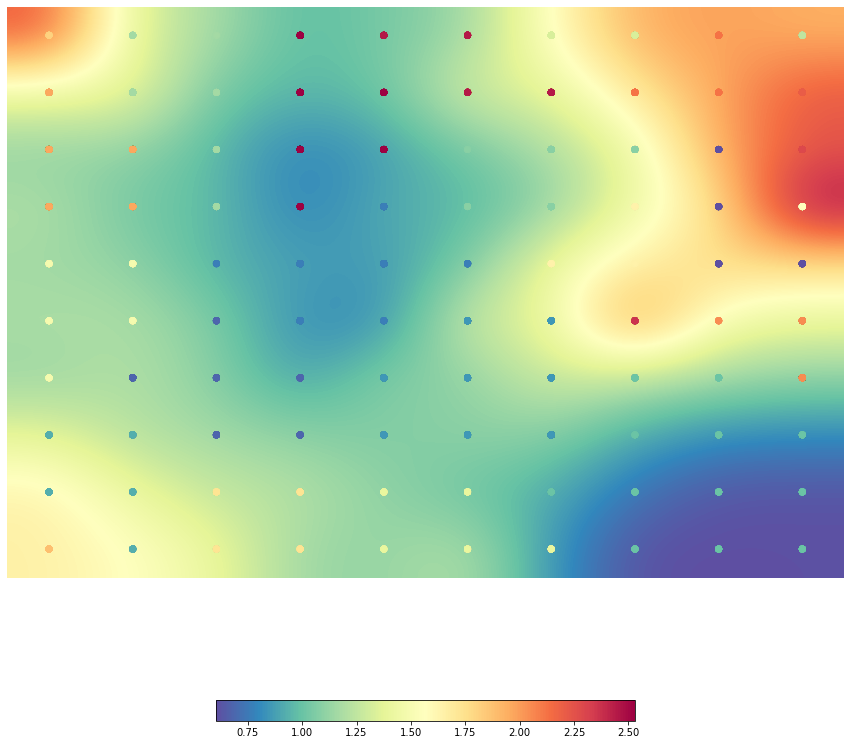

[[15  7  7 24 23 23  9  9 19  8]
 [17  7  7 24 24 23 23 19 19 20]
 [17 17  7 24 24  6  6  6  0 21]
 [17 17  7 24  2  6  6 13  0 12]
 [11 11  2  2  2  2 13 13  0  0]
 [11 11  1  2  2  3  3 22 18 18]
 [11  1  1  1  3  3  3  5  5 18]
 [ 4  4  1  1  3  3  3  5  5  5]
 [ 4  4 14 14 10 10  5  5  5  5]
 [16  4 14 14 10 10 10  5  5  5]]
Cluster 12 has 1 neurons
Cluster 22 has 1 neurons
Cluster 21 has 1 neurons
Cluster 20 has 1 neurons
Cluster 16 has 1 neurons
Cluster 15 has 1 neurons
Cluster 8 has 1 neurons
Cluster 9 has 2 neurons
Cluster 19 has 3 neurons
Cluster 18 has 3 neurons
Cluster 13 has 3 neurons
Cluster 14 has 4 neurons
Cluster 0 has 4 neurons
Cluster 23 has 4 neurons
Cluster 11 has 5 neurons
Cluster 10 has 5 neurons
Cluster 6 has 5 neurons
Cluster 17 has 5 neurons
Cluster 4 has 5 neurons
Cluster 7 has 6 neurons
Cluster 1 has 6 neurons
Cluster 24 has 6 neurons
Cluster 2 has 7 neurons
Cluster 3 has 8 neurons
Cluster 5 has 12 neurons


In [49]:
som_view_umatrix(som10)

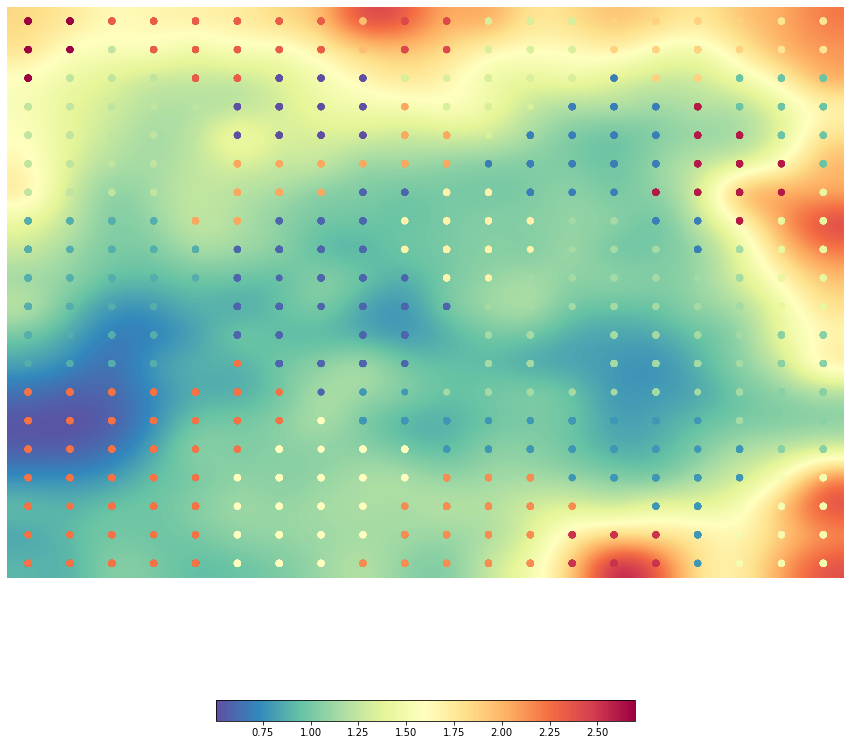

[[24 24 20 20 20 20 20 20 16 21 21  9  9  9 15 15 15 15 14 14]
 [24 24  8 20 20 20 20 20 16 21 21  9  9  9 15 15 15 15 14 14]
 [24  8  8  8 20 20  0  0  0  9  9  9  9  9  2 15 15  5  5  5]
 [ 8  8  8  8  8  0  0  0  0 17  9  9  9  2  2  2 23  5  5  5]
 [ 8  8  8  8  8  0  0  0  0 17 17  9  2  2  2  2 23 23  5  5]
 [ 8  8  8  8  8 17 17 17 17 17 17  2  2  2  2  2 23 23 23  5]
 [ 8  8  8  8  8 17 17 17  1  1 13 13  2  2  2 23 23 23 23 10]
 [ 4  4  4  4 17 17  1  1  1 13 13 13 13  7  7  2  2 23 10 10]
 [ 4  4  4  4  4  1  1  1  1 13 13 13 13  7  7  7  2  7 10 10]
 [ 4  4  4  4  4  1  1  1  1  1 13 13  7  7  7  7  7  7 10 10]
 [ 4  4  4  4  4  1  1  1  1  1  1  7  7  7  7  7  7  7 10 10]
 [ 4  4  4  4 19  1  1  1  1  1  1  7  7  7  7  7  7  7  6  6]
 [ 4  4  4  4  4 19  1  1  1  1  7  7  7  7  7  7  7  7  6  6]
 [19 19 19 19 19 19 19  1  3  3  7  7  7  7  7  7  7  7  6  6]
 [19 19 19 19 19 19 19 12  3  3  3  3  3  3  3  3  3  7  6  6]
 [19 19 19 19 19 19 12 12 12 12  3  3  3  3  3  3  3  3

In [50]:
som_view_umatrix(som20)

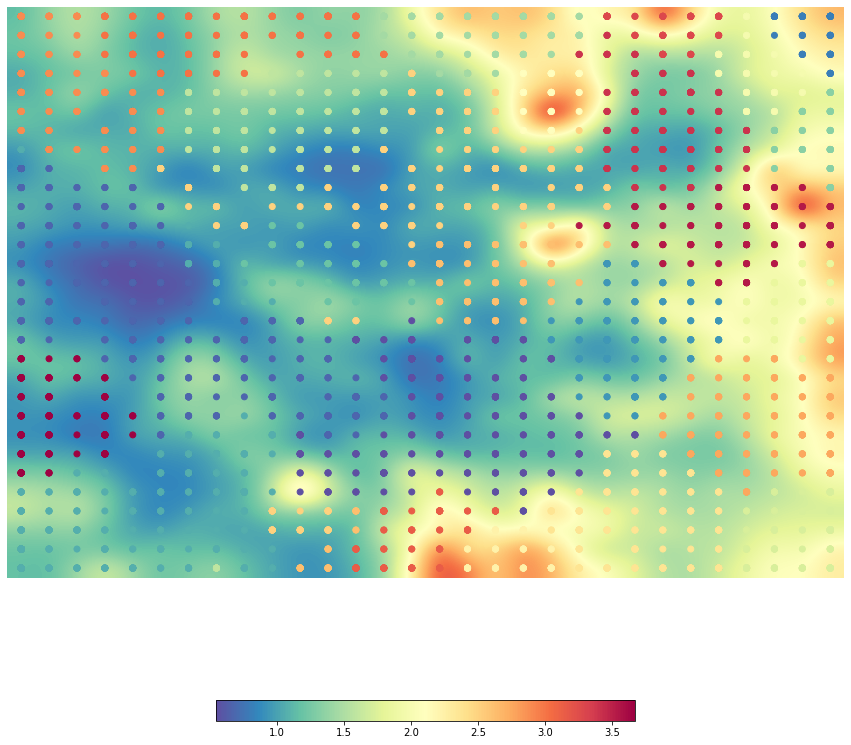

[[18 18 18 19 19 19 19 19 19 19 19 19 19  7  7  7  7  7  7  7  7 21 21 21
  21 21 11  2  2  2]
 [18 18 18 19 19 19 19 19 19 19 19 19 19  7  7  7  7  7  7  7  7 22 21 21
  21 21 11  2  2  2]
 [18 18 18 19 19 19 19 19 19 19 19 19 19 19  7  7  7  7  7  7 22 22 22 21
  21 11 11 11  2  2]
 [18 18 18 18 19 19 19 19 19  8  8  8  8  8 15  7  7  7 12 12 12 22 22 22
  22 11 11 11 11  2]
 [18 18 18 18 18 18  8  8  8  8  8  8  8  8 15 15 15 15 12 12 12 22 22 22
  22 22 11 11 11  6]
 [18 18 18 18 18 18  8  8  8  8  8  8  8  8 15 15 15 15 12 12 12 22 22 22
  22 22 11 11  6  6]
 [18 18 18 18 18 18  8  8  8  8  8  8  8  8 15 15 15 15 12 12 15 22 22 22
  22 22 22  6  6  6]
 [ 4 18 18 18 18 18  8  8  8  8  8  8  8 15 15 15 15 15 15 15 15 22 22 22
  22 22 22  6  6  6]
 [ 1  1  1 18 18 15 15  8  8  8  8  8  8 15 15 15 15 15 15 15 15 22 22 22
  22 22 22  6  6  6]
 [ 1  1  1  1  1 15 15  8  8  8  8 15 15 15 15 15 15 15 15 15 15 15 22 22
  22 23 23 23 23  6]
 [ 1  1  1  1  1  1 15 15 15 15 15 15 15 15 15 15 

In [51]:
som_view_umatrix(som30)

In [81]:
algorithm = KMeans(n_clusters=35)
som10.cluster(algorithm=algorithm)
som20.cluster(algorithm=algorithm)
som30.cluster(algorithm=algorithm)

/usr/local/lib/python3.8/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


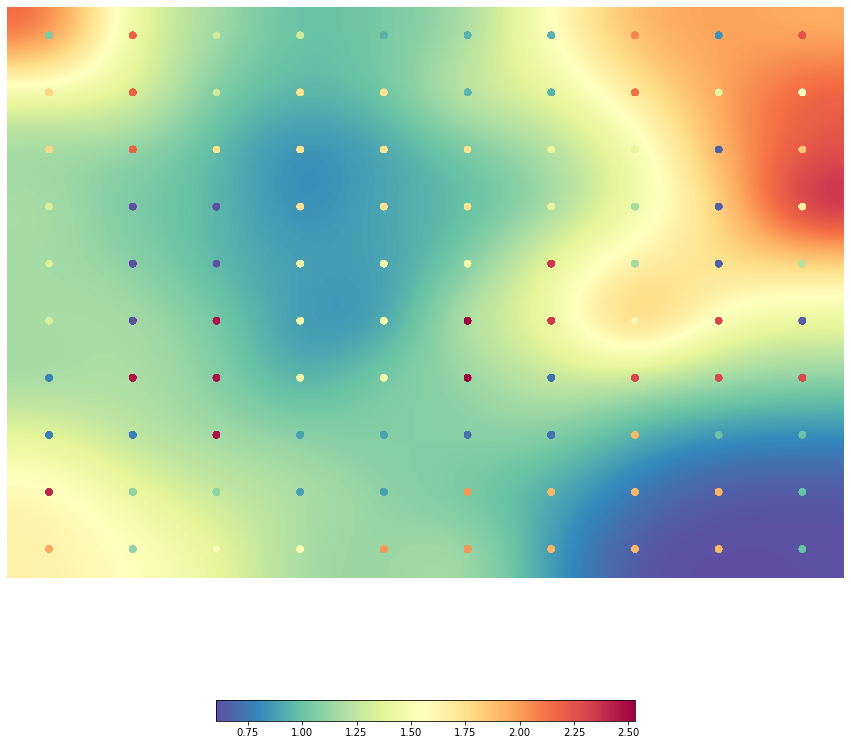

[[ 8 28 12 12  6  6  6 26  4 29]
 [21 28 12 20 20  6  6 27 14 17]
 [21 28 20 20 20 20 14 14  1 22]
 [13  0  0 20 20 20 14 10  1 19]
 [13  0  0 15 15 15 31 10  1 11]
 [13  0 33 15 15 34 31 18 30  1]
 [ 3 33 33 15 15 34  2 30 30 30]
 [ 3  3 33  5  5  2  2 23  7  7]
 [32  9  9  5  5 25 23 23 23  7]
 [24  9 16 16 25 25 23 23 23  7]]
Cluster 17 has 1 neurons
Cluster 32 has 1 neurons
Cluster 29 has 1 neurons
Cluster 4 has 1 neurons
Cluster 27 has 1 neurons
Cluster 26 has 1 neurons
Cluster 24 has 1 neurons
Cluster 8 has 1 neurons
Cluster 22 has 1 neurons
Cluster 11 has 1 neurons
Cluster 19 has 1 neurons
Cluster 18 has 1 neurons
Cluster 31 has 2 neurons
Cluster 21 has 2 neurons
Cluster 16 has 2 neurons
Cluster 34 has 2 neurons
Cluster 10 has 2 neurons
Cluster 25 has 3 neurons
Cluster 13 has 3 neurons
Cluster 12 has 3 neurons
Cluster 2 has 3 neurons
Cluster 9 has 3 neurons
Cluster 3 has 3 neurons
Cluster 28 has 3 neurons
Cluster 1 has 4 neurons
Cluster 30 has 4 neurons
Cluster 5 has 4 neurons
C

In [83]:
som_view_umatrix(som10)

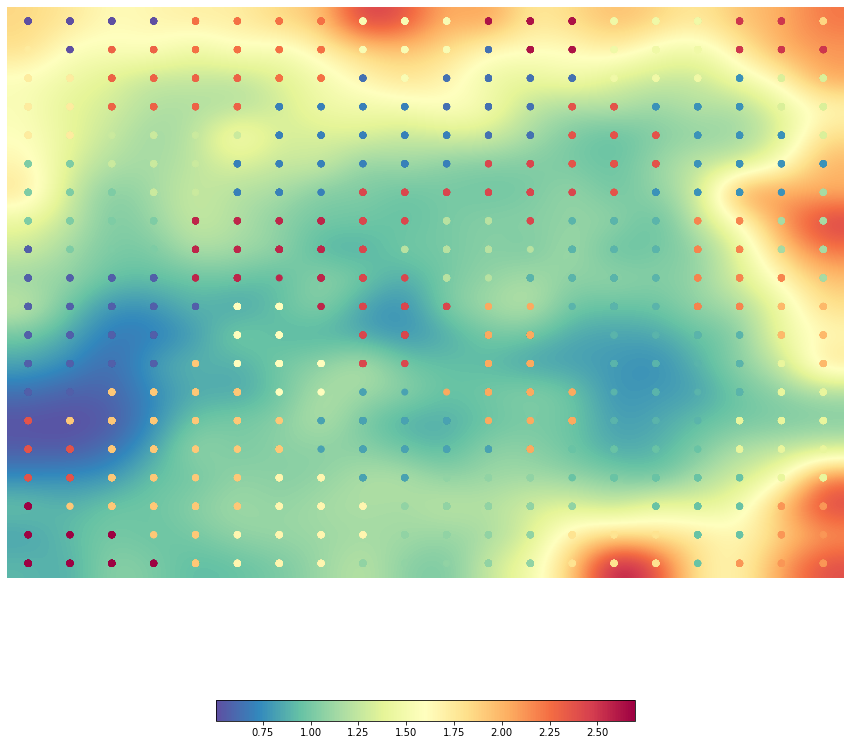

[[ 0  0  0  0 27 27 27 27 16 16 16 33 33 33 15 15 15 31 31 21]
 [19  0 28 28 27 27 27 27 16 16 16  2 33 33 15 15 15 31 31 31]
 [19 19 28 28 28 28 27 27  2 16  2  2  2  2 15 15 15  4 13 13]
 [19 19 28 28 28 28  3  3  3  3  2  2  2 29 29  4  4  4 13 13]
 [19 19 12 12 12 12  3  3  3  3  3  2  2 29 29 29  4  4  4 13]
 [ 8  8 12 12 12  3  3  3  3  3  3 30 30 29 29 29  4  4  4  4]
 [ 8  8  8 12 12  3  3  3 30 30 30 30 30 30 29  4  4  4  4 10]
 [ 8  8  8  8 32 32 32 32 30 30 11 11 30  6  6  6 26 26 10 10]
 [ 1  8  8  8 32 32 32 32 30 11 11 11 11  6  6  6 26 26 10 10]
 [ 1  1  1  1 32 32 32 32 30 30 11 11  6  6  6  6 26 26 26 10]
 [ 1  1  1  1  1 17 17 32 30 30 30 24 24  6  6  6 26 26 23 23]
 [ 1  1  1  1 22 17 17 17 30 30 30 24 24 24  6  6  6  6 23 23]
 [ 1  1  1  1 22 17 17 17 30 30 24 24 24 24  6  6  6  6 14 23]
 [ 1  1 22 22 22 22 17 17  5  5 24 24 24 24  6  6  6  6 14 14]
 [29 22 22 22 22 22 22  5  5  5  5 24 24 24  6  6  6 14 14 14]
 [29 29 22 22 22 22 22  5  5  5  5  5 24  7  7  7  7 14

In [84]:
som_view_umatrix(som20)

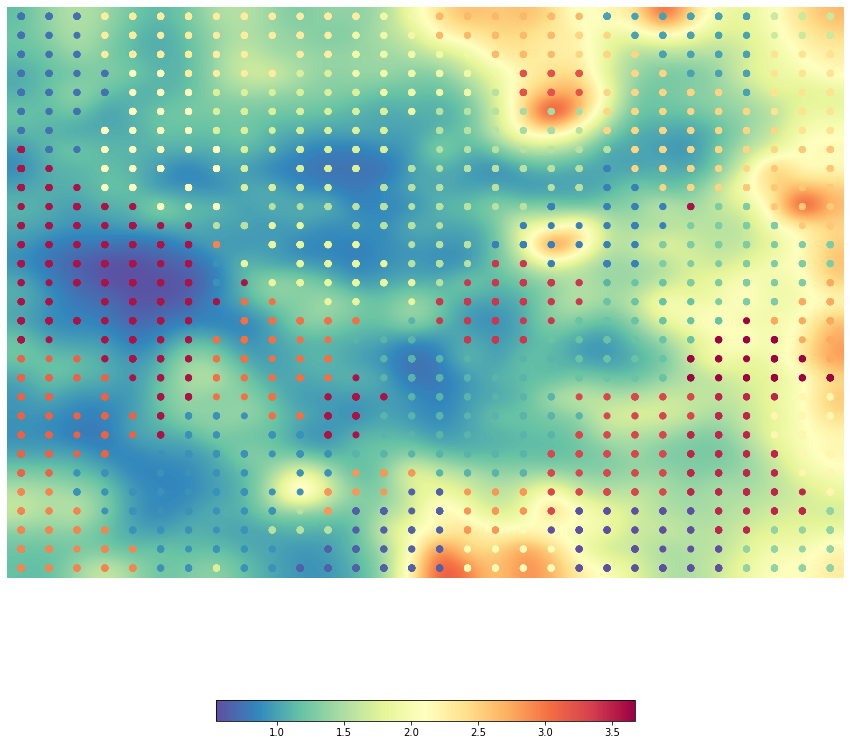

[[ 2  2  2 19 19 19 19 19 19 19 19 19 19 15 15 23 23 23 23 23 23  5  5  5
   5  5  5 12 12 12]
 [ 2  2  2 19 19 19 19 19 19 19 19 19 15 15 15 23 23 23 23 23 21 21  5  5
   5  5  5 12 12 12]
 [ 2  2  2 19 19 19 19 19 19 19 19 19 15 15 15 15 15 23 23 23 21 21 21  5
   5  5  5 20 20 20]
 [ 2  2  2  2 17 17 19 19 19 19 13 13 15 15 15 15 15 15 29 29 29 21 21 21
   5  5  5 20 20 20]
 [ 2  2  2  2 17 17 17 13 13 13 13 13 13 15 15 15 15 11 29 29 29 21 21 21
  21 21  5 20 20 20]
 [ 2  2  2 17 17 17 17 13 13 13 13 13 13 13 15 11 11 11 10 10 10 21 21 21
  21 21 21 20 20 20]
 [ 2  2  2 17 17 17 17 13 13 13 13 13 13 13 11 11 11 11 10 10 11 21 21 21
  21 21 21 21 20 20]
 [33  2  2 17 17 17 17 17 13 13 13 13 13 13 11 11 11 11 11 11 11 11 21 21
  21 21 21 21 22 22]
 [33 33 33 17 17 17 17 17 13 13 13 13 13 11 11 11 11 11 11 11 11  3 21 21
  21 21 21 22 22 22]
 [33 33 33 17 17 17 17 17 13 13 13 13 11 11 11 11 11 11 11 11 11  3  3 21
  21 21 22 22 22 22]
 [33 33 33 33 33 17 17 17 11 11 11 11 11 11 11 11 

In [85]:
som_view_umatrix(som30)

## Τελικό SOM: 30x30, k=35

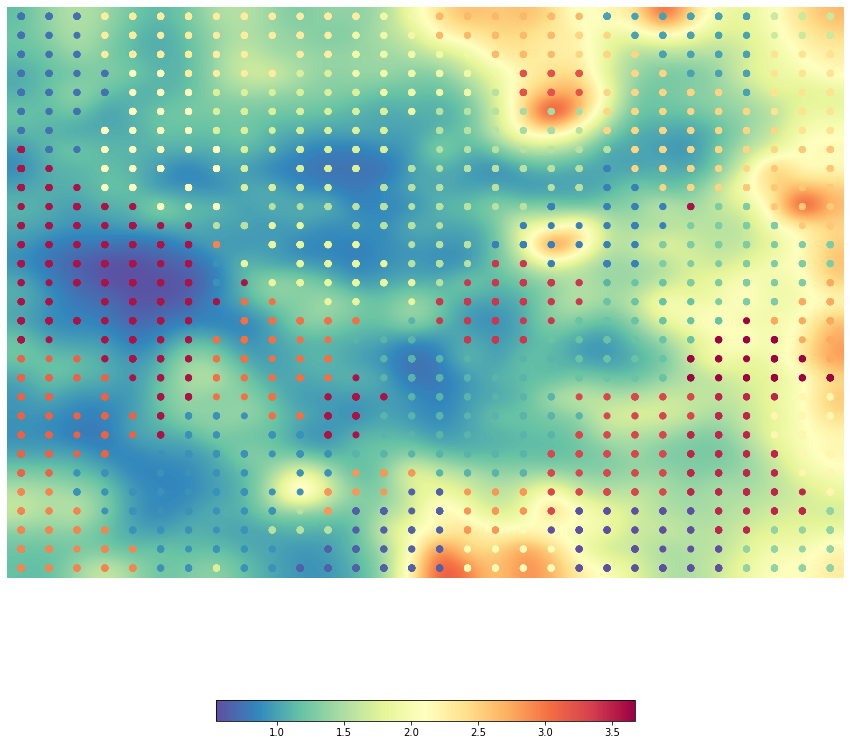

[[ 2  2  2 19 19 19 19 19 19 19 19 19 19 15 15 23 23 23 23 23 23  5  5  5
   5  5  5 12 12 12]
 [ 2  2  2 19 19 19 19 19 19 19 19 19 15 15 15 23 23 23 23 23 21 21  5  5
   5  5  5 12 12 12]
 [ 2  2  2 19 19 19 19 19 19 19 19 19 15 15 15 15 15 23 23 23 21 21 21  5
   5  5  5 20 20 20]
 [ 2  2  2  2 17 17 19 19 19 19 13 13 15 15 15 15 15 15 29 29 29 21 21 21
   5  5  5 20 20 20]
 [ 2  2  2  2 17 17 17 13 13 13 13 13 13 15 15 15 15 11 29 29 29 21 21 21
  21 21  5 20 20 20]
 [ 2  2  2 17 17 17 17 13 13 13 13 13 13 13 15 11 11 11 10 10 10 21 21 21
  21 21 21 20 20 20]
 [ 2  2  2 17 17 17 17 13 13 13 13 13 13 13 11 11 11 11 10 10 11 21 21 21
  21 21 21 21 20 20]
 [33  2  2 17 17 17 17 17 13 13 13 13 13 13 11 11 11 11 11 11 11 11 21 21
  21 21 21 21 22 22]
 [33 33 33 17 17 17 17 17 13 13 13 13 13 11 11 11 11 11 11 11 11  3 21 21
  21 21 21 22 22 22]
 [33 33 33 17 17 17 17 17 13 13 13 13 11 11 11 11 11 11 11 11 11  3  3 21
  21 21 22 22 22 22]
 [33 33 33 33 33 17 17 17 11 11 11 11 11 11 11 11 

In [86]:
som_view_umatrix(som30)


## Σημασιολογική ερμηνεία των clusters

Προκειμένου να μελετήσουμε τις τοπολογικές ιδιότητες του SOM και το αν έχουν ενσωματώσει σημασιολογική πληροφορία για τις ταινίες διαμέσου της διανυσματικής αναπαράστασης του tf-idf, των εμφυτευμάτων και των κατηγοριών, χρειαζόμαστε ένα κριτήριο ποιοτικής επισκόπησης των clusters. 

Θα υλοποιήσουμε το εξής κριτήριο: Λαμβάνουμε όρισμα έναν αριθμό (ετικέτα) cluster. Για το cluster αυτό βρίσκουμε όλους τους νευρώνες που του έχουν ανατεθεί από τον k-Means. Για όλους τους νευρώνες αυτούς βρίσκουμε όλες τις ταινίες που τους έχουν ανατεθεί (για τις οποίες αποτελούν bmus). Για όλες αυτές τις ταινίες τυπώνουμε ταξινομημένη τη συνολική στατιστική όλων των ειδών (κατηγοριών) και τις συχνότητές τους. Αν το cluster διαθέτει καλή συνοχή και εξειδίκευση, θα πρέπει κάποιες κατηγορίες να έχουν σαφώς μεγαλύτερη συχνότητα από τις υπόλοιπες. Θα μπορούμε τότε να αναθέσουμε αυτήν/ές την/τις κατηγορία/ες ως ετικέτες κινηματογραφικού είδους στο cluster.

Μπορείτε να υλοποιήσετε τη συνάρτηση αυτή όπως θέλετε. Μια πιθανή διαδικασία θα μπορούσε να είναι η ακόλουθη:

1. Ορίζουμε συνάρτηση `print_categories_stats` που δέχεται ως είσοδο λίστα με ids ταινιών. Δημιουργούμε μια κενή λίστα συνολικών κατηγοριών. Στη συνέχεια, για κάθε ταινία επεξεργαζόμαστε το string `categories` ως εξής: δημιουργούμε μια λίστα διαχωρίζοντας το string κατάλληλα με την `split` και αφαιρούμε τα whitespaces μεταξύ ετικετών με την `strip`. Προσθέτουμε τη λίστα αυτή στη συνολική λίστα κατηγοριών με την `extend`. Τέλος χρησιμοποιούμε πάλι την `np.unique` για να μετρήσουμε συχνότητα μοναδικών ετικετών κατηγοριών και ταξινομούμε με την `np.argsort`. Τυπώνουμε τις κατηγορίες και τις συχνότητες εμφάνισης ταξινομημένα. Χρήσιμες μπορεί να σας φανούν και οι `np.ravel`, `np.nditer`, `np.array2string` και `zip`.

2. Ορίζουμε τη βασική μας συνάρτηση `print_cluster_neurons_movies_report` που δέχεται ως όρισμα τον αριθμό ενός cluster. Με τη χρήση της `np.where` μπορούμε να βρούμε τις συντεταγμένες των bmus που αντιστοιχούν στο cluster και με την `column_stack` να φτιάξουμε έναν πίνακα bmus για το cluster. Προσοχή στη σειρά (στήλη - σειρά) στον πίνακα bmus. Για κάθε bmu αυτού του πίνακα ελέγχουμε αν υπάρχει στον πίνακα μοναδικών bmus που έχουμε υπολογίσει στην αρχή συνολικά και αν ναι προσθέτουμε το αντίστοιχο index του νευρώνα σε μια λίστα. Χρήσιμες μπορεί να είναι και οι `np.rollaxis`, `np.append`, `np.asscalar`. Επίσης πιθανώς να πρέπει να υλοποιήσετε ένα κριτήριο ομοιότητας μεταξύ ενός bmu και ενός μοναδικού bmu από τον αρχικό πίνακα bmus.

3. Υλοποιούμε μια βοηθητική συνάρτηση `neuron_movies_report`. Λαμβάνει ένα σύνολο νευρώνων από την `print_cluster_neurons_movies_report` και μέσω της `indices` φτιάχνει μια λίστα με το σύνολο ταινιών που ανήκουν σε αυτούς τους νευρώνες. Στο τέλος καλεί με αυτή τη λίστα την `print_categories_stats` που τυπώνει τις στατιστικές των κατηγοριών.

Μπορείτε βέβαια να προσθέσετε οποιαδήποτε επιπλέον έξοδο σας βοηθάει. Μια χρήσιμη έξοδος είναι πόσοι νευρώνες ανήκουν στο cluster και σε πόσους και ποιους από αυτούς έχουν ανατεθεί ταινίες.

Θα επιτελούμε τη σημασιολογική ερμηνεία του χάρτη καλώντας την `print_cluster_neurons_movies_report` με τον αριθμός ενός cluster που μας ενδιαφέρει. 

Παράδειγμα εξόδου για ένα cluster (μη βελτιστοποιημένος χάρτης, ωστόσο βλέπετε ότι οι μεγάλες κατηγορίες έχουν σημασιολογική  συνάφεια):

```
Overall Cluster Genres stats:  
[('"Horror"', 86), ('"Science Fiction"', 24), ('"B-movie"', 16), ('"Monster movie"', 10), ('"Creature Film"', 10), ('"Indie"', 9), ('"Zombie Film"', 9), ('"Slasher"', 8), ('"World cinema"', 8), ('"Sci-Fi Horror"', 7), ('"Natural horror films"', 6), ('"Supernatural"', 6), ('"Thriller"', 6), ('"Cult"', 5), ('"Black-and-white"', 5), ('"Japanese Movies"', 4), ('"Short Film"', 3), ('"Drama"', 3), ('"Psychological thriller"', 3), ('"Crime Fiction"', 3), ('"Monster"', 3), ('"Comedy"', 2), ('"Western"', 2), ('"Horror Comedy"', 2), ('"Archaeology"', 2), ('"Alien Film"', 2), ('"Teen"', 2), ('"Mystery"', 2), ('"Adventure"', 2), ('"Comedy film"', 2), ('"Combat Films"', 1), ('"Chinese Movies"', 1), ('"Action/Adventure"', 1), ('"Gothic Film"', 1), ('"Costume drama"', 1), ('"Disaster"', 1), ('"Docudrama"', 1), ('"Film adaptation"', 1), ('"Film noir"', 1), ('"Parody"', 1), ('"Period piece"', 1), ('"Action"', 1)]```
   

In [87]:
def print_categories_stats(id_list):
    total_categories = []
    for i in id_list:
        temp = categories[i][0].replace('"', "").split(',')
        temp = [category.strip() for category in temp]
        total_categories.extend(temp)
    (ucategories, counts) = np.unique(total_categories, return_counts=True)
    sorted_indexes = np.argsort(counts)
    sorted_categories = [ucategories[i] for i in sorted_indexes][::-1]#reverse
    freq = dict(zip(sorted_categories, sorted(counts)[::-1]))
    print(freq)

print_categories_stats(range(0,5000))

{'Drama': 2266, 'Comedy': 1241, 'Thriller': 809, 'Romance Film': 753, 'Action': 701, 'World cinema': 553, 'Crime Fiction': 517, 'Horror': 500, 'Action/Adventure': 445, 'Black-and-white': 443, 'Indie': 397, 'Family Film': 387, 'Adventure': 374, 'Short Film': 371, 'Science Fiction': 299, 'Mystery': 285, 'Musical': 285, 'Animation': 280, 'Romantic drama': 268, 'Romantic comedy': 248, 'Fantasy': 239, 'Crime Thriller': 214, 'Comedy film': 201, 'War film': 184, 'Period piece': 153, 'Psychological thriller': 151, 'Comedy-drama': 144, 'Japanese Movies': 143, 'Film adaptation': 142, 'Documentary': 134, 'Bollywood': 132, 'Silent film': 126, 'Western': 115, 'Chinese Movies': 112, 'Teen': 107, 'Television movie': 103, 'Parody': 102, 'Black comedy': 99, "Children's/Family": 97, 'Family Drama': 90, 'Sports': 87, 'Martial Arts Film': 85, 'Cult': 85, 'Coming of age': 83, 'Slasher': 77, 'Biographical film': 76, 'Supernatural': 75, 'Biography': 72, 'Film noir': 71, 'Melodrama': 70, 'Suspense': 65, 'Sati

In [88]:
def print_cluster_neurons_movies_report(cluster,mysom,myubmus):
  x,y = np.where(mysom.clusters==cluster)
  coords = np.column_stack((x,y))
  # neurons = [(mysom.clusters.shape[0]*coords[i][1]+coords[i][0]) for i in coords if coords[i] in myubmus]
  neurons = []
  for i in range(len(coords)):
        for ubmu in myubmus:
            if coords[i][0] == ubmu[0] and coords[i][1]==ubmu[1]:
                neurons.append(ubmu[1]*mysom.clusters.shape[0] + ubmu[0]) 
                break
  # print(neurons)
  return neurons

print_cluster_neurons_movies_report(29,som30,ubmus30)

[543, 573, 603, 544, 574]

In [89]:
def neuron_movies_report(neurons,myindices):
    movies = []
    for coord in neurons:
        movies.extend(np.where(myindices==coord)[0])
    return print_categories_stats(movies)


## Tips για το SOM και το clustering

- Για την ομαδοποίηση ένα U-matrix καλό είναι να εμφανίζει και μπλε-πράσινες περιοχές (clusters) και κόκκινες περιοχές (ορίων). Παρατηρήστε ποια σχέση υπάρχει μεταξύ αριθμού ταινιών στο final set, μεγέθους grid και ποιότητας U-matrix.
- Για το k του k-Means προσπαθήστε να προσεγγίζει σχετικά τα clusters του U-matrix (όπως είπαμε είναι διαφορετικοί μέθοδοι clustering). Μικρός αριθμός k δεν θα σέβεται τα όρια. Μεγάλος αριθμός θα δημιουργεί υπο-clusters εντός των clusters που φαίνονται στο U-matrix. Το τελευταίο δεν είναι απαραίτητα κακό, αλλά μεγαλώνει τον αριθμό clusters που πρέπει να αναλυθούν σημασιολογικά.
- Σε μικρούς χάρτες και με μικρά final sets δοκιμάστε διαφορετικές παραμέτρους για την εκπαίδευση του SOM. Σημειώστε τυχόν παραμέτρους που επηρεάζουν την ποιότητα του clustering για το dataset σας ώστε να τις εφαρμόσετε στους μεγάλους χάρτες.
- Κάποια τοπολογικά χαρακτηριστικά εμφανίζονται ήδη σε μικρούς χάρτες. Κάποια άλλα χρειάζονται μεγαλύτερους χάρτες. Δοκιμάστε μεγέθη 20x20, 25x25 ή και 30x30 και αντίστοιχη προσαρμογή των k. Όσο μεγαλώνουν οι χάρτες, μεγαλώνει η ανάλυση του χάρτη αλλά μεγαλώνει και ο αριθμός clusters που πρέπει να αναλυθούν.




## Ανάλυση τοπολογικών ιδιοτήτων χάρτη SOM

Μετά το πέρας της εκπαίδευσης και του clustering θα έχετε ένα χάρτη με τοπολογικές ιδιότητες ως προς τα είδη των ταίνιών της συλλογής σας, κάτι αντίστοιχο με την εικόνα στην αρχή της Εφαρμογής 2 αυτού του notebook. Η συγκεκριμένη εικόνα είναι μόνο για εικονογράφιση, δεν είναι χάρτης SOM καιδεν έχει καμία σχέση με τη συλλογή δεδομένων και τις κατηγορίες μας.

Για τον τελικό χάρτη SOM που θα παράξετε για τη συλλογή σας, αναλύστε σε markdown με συγκεκριμένη αναφορά σε αριθμούς clusters και τη σημασιολογική ερμηνεία τους τις εξής τρεις τοπολογικές ιδιότητες του SOM: 

1. Δεδομένα που έχουν μεγαλύτερη πυκνότητα πιθανότητας στο χώρο εισόδου τείνουν να απεικονίζονται με περισσότερους νευρώνες στο χώρο μειωμένης διαστατικότητας. Δώστε παραδείγματα από συχνές και λιγότερο συχνές κατηγορίες ταινιών. Χρησιμοποιήστε τις στατιστικές των κατηγοριών στη συλλογή σας και τον αριθμό κόμβων που χαρακτηρίζουν.
2. Μακρινά πρότυπα εισόδου τείνουν να απεικονίζονται απομακρυσμένα στο χάρτη. Υπάρχουν χαρακτηριστικές κατηγορίες ταινιών που ήδη από μικρούς χάρτες τείνουν να τοποθετούνται σε διαφορετικά ή απομονωμένα σημεία του χάρτη.
3. Κοντινά πρότυπα εισόδου τείνουν να απεικονίζονται κοντά στο χάρτη. Σε μεγάλους χάρτες εντοπίστε είδη ταινιών και κοντινά τους υποείδη.

Προφανώς τοποθέτηση σε 2 διαστάσεις που να σέβεται μια απόλυτη τοπολογία δεν είναι εφικτή, αφενός γιατί δεν υπάρχει κάποια απόλυτη εξ ορισμού για τα κινηματογραφικά είδη ακόμα και σε πολλές διαστάσεις, αφετέρου γιατί πραγματοποιούμε μείωση διαστατικότητας.

4. Εντοπίστε μεγάλα clusters και μικρά clusters που δεν έχουν σαφή χαρακτηριστικά. Εντοπίστε clusters συγκεκριμένων ειδών που μοιάζουν να μην έχουν τοπολογική συνάφεια με γύρω περιοχές. Προτείνετε πιθανές ερμηνείες.


5. Τέλος, εντοπίστε clusters που έχουν κατά την άποψή σας ιδιαίτερο ενδιαφέρον στη συλλογή της ομάδας σας (data exploration / discovery value) και σχολιάστε.


### Απαντήσεις

In [90]:
print_categories_stats(range(0,5000))

{'Drama': 2266, 'Comedy': 1241, 'Thriller': 809, 'Romance Film': 753, 'Action': 701, 'World cinema': 553, 'Crime Fiction': 517, 'Horror': 500, 'Action/Adventure': 445, 'Black-and-white': 443, 'Indie': 397, 'Family Film': 387, 'Adventure': 374, 'Short Film': 371, 'Science Fiction': 299, 'Mystery': 285, 'Musical': 285, 'Animation': 280, 'Romantic drama': 268, 'Romantic comedy': 248, 'Fantasy': 239, 'Crime Thriller': 214, 'Comedy film': 201, 'War film': 184, 'Period piece': 153, 'Psychological thriller': 151, 'Comedy-drama': 144, 'Japanese Movies': 143, 'Film adaptation': 142, 'Documentary': 134, 'Bollywood': 132, 'Silent film': 126, 'Western': 115, 'Chinese Movies': 112, 'Teen': 107, 'Television movie': 103, 'Parody': 102, 'Black comedy': 99, "Children's/Family": 97, 'Family Drama': 90, 'Sports': 87, 'Martial Arts Film': 85, 'Cult': 85, 'Coming of age': 83, 'Slasher': 77, 'Biographical film': 76, 'Supernatural': 75, 'Biography': 72, 'Film noir': 71, 'Melodrama': 70, 'Suspense': 65, 'Sati

In [97]:
neuron_movies_report(print_cluster_neurons_movies_report(33,som30,ubmus30),indices30)

{'Drama': 495, 'Crime Fiction': 107, 'World cinema': 100, 'Romance Film': 77, 'Black-and-white': 63, 'Action': 57, 'Action/Adventure': 55, 'Comedy': 48, 'Thriller': 38, 'Indie': 35, 'Adventure': 29, 'Musical': 26, 'Film adaptation': 23, 'Melodrama': 21, 'Political drama': 21, 'Period piece': 19, 'Comedy film': 15, 'Japanese Movies': 14, 'Martial Arts Film': 14, 'Coming of age': 13, 'Biographical film': 13, 'Film noir': 13, 'Crime Drama': 13, 'Gangster Film': 12, 'Silent film': 12, 'Horror': 12, 'Chinese Movies': 12, 'Art film': 12, 'Bollywood': 12, 'Television movie': 11, 'Family Film': 11, 'War film': 11, 'Crime Thriller': 10, 'Family Drama': 10, 'Biopic [feature]': 10, 'Western': 9, 'Documentary': 9, 'Mystery': 9, 'Short Film': 9, 'Filipino Movies': 8, 'Sports': 8, 'History': 8, 'Action Thrillers': 8, 'Romantic drama': 8, 'Music': 7, 'Courtroom Drama': 7, 'Fantasy': 6, 'Ensemble Film': 6, 'Crime Comedy': 6, 'Costume drama': 6, 'Black comedy': 6, 'Teen': 6, 'Biography': 6, 'Romantic c


1) H κατηγορία Drama είναι η πιο συχνή κατηγορία σε όλο το dataset.
Παρατηρούμε ότι στο cluster 33 η πιο συχνή κατηγορία είναι η Drama. Εφόσον οι ταινίες με είδος Drama έχουν μεγαλύτερη πυκνότητα πιθανότητας στο χώρο εισόδου τείνουν να εμφανίζονται με μεγαλύτερο αριθμό νευρώνων στο χάρτη. Αυτό επιβεβαιώνεται και στο cluster 33, το οποίο αποτελείται απο 83 νευρώνες και είναι το μεγαλύτερο cluster σε όλο το χάρτη. Παράλληλα η κατηγορία drama εμφανίζεται στους περισότερους νευρώνες του χάρτη(αντιστοιχείται σε πολλούς νευρώνες).

In [102]:
neuron_movies_report(print_cluster_neurons_movies_report(33,som30,ubmus30),indices30)
neuron_movies_report(print_cluster_neurons_movies_report(11,som30,ubmus30),indices30)

{'Drama': 495, 'Crime Fiction': 107, 'World cinema': 100, 'Romance Film': 77, 'Black-and-white': 63, 'Action': 57, 'Action/Adventure': 55, 'Comedy': 48, 'Thriller': 38, 'Indie': 35, 'Adventure': 29, 'Musical': 26, 'Film adaptation': 23, 'Melodrama': 21, 'Political drama': 21, 'Period piece': 19, 'Comedy film': 15, 'Japanese Movies': 14, 'Martial Arts Film': 14, 'Coming of age': 13, 'Biographical film': 13, 'Film noir': 13, 'Crime Drama': 13, 'Gangster Film': 12, 'Silent film': 12, 'Horror': 12, 'Chinese Movies': 12, 'Art film': 12, 'Bollywood': 12, 'Television movie': 11, 'Family Film': 11, 'War film': 11, 'Crime Thriller': 10, 'Family Drama': 10, 'Biopic [feature]': 10, 'Western': 9, 'Documentary': 9, 'Mystery': 9, 'Short Film': 9, 'Filipino Movies': 8, 'Sports': 8, 'History': 8, 'Action Thrillers': 8, 'Romantic drama': 8, 'Music': 7, 'Courtroom Drama': 7, 'Fantasy': 6, 'Ensemble Film': 6, 'Crime Comedy': 6, 'Costume drama': 6, 'Black comedy': 6, 'Teen': 6, 'Biography': 6, 'Romantic c

2) Θα χρησιμοποιήσουμε ως αναφορά τα clusters 33 και 11. Το 33 βρίσκεται αριστερά και στο κέντρο του χάρτη, ενω το 11 βρίσκεται δεξιά . Βλέπουμε ότι οι ταινίες που αντιστοιχούν στο κάθε cluster έχουν διαφορετικές κατηγορίες κατά κύριο λόγο. Στο cluster 33 βρίσκονται κατά κύριο λόγο ταινίες των κατηγοριών:
* Drama 
* Crime Fiction
* World cinema
* Romance Film
* Black-and-white

Στο cluster 11 βρίσκονται κατά κύριο λόγο ταινίες των κατηγοριών:
* Comedy 
* Short Film
* Black-and-white
* Romance Film
* Horror
Υπάρχει μια μικρή επικάλυψη ειδών αλλά η μεγάλη πλειοψηφία σε κάθε cluster ανήκει στο πρώτο είδος(33-drama/11-comedy).

In [103]:
neuron_movies_report(print_cluster_neurons_movies_report(33,som30,ubmus30),indices30)
neuron_movies_report(print_cluster_neurons_movies_report(28,som30,ubmus30),indices30)

{'Drama': 495, 'Crime Fiction': 107, 'World cinema': 100, 'Romance Film': 77, 'Black-and-white': 63, 'Action': 57, 'Action/Adventure': 55, 'Comedy': 48, 'Thriller': 38, 'Indie': 35, 'Adventure': 29, 'Musical': 26, 'Film adaptation': 23, 'Melodrama': 21, 'Political drama': 21, 'Period piece': 19, 'Comedy film': 15, 'Japanese Movies': 14, 'Martial Arts Film': 14, 'Coming of age': 13, 'Biographical film': 13, 'Film noir': 13, 'Crime Drama': 13, 'Gangster Film': 12, 'Silent film': 12, 'Horror': 12, 'Chinese Movies': 12, 'Art film': 12, 'Bollywood': 12, 'Television movie': 11, 'Family Film': 11, 'War film': 11, 'Crime Thriller': 10, 'Family Drama': 10, 'Biopic [feature]': 10, 'Western': 9, 'Documentary': 9, 'Mystery': 9, 'Short Film': 9, 'Filipino Movies': 8, 'Sports': 8, 'History': 8, 'Action Thrillers': 8, 'Romantic drama': 8, 'Music': 7, 'Courtroom Drama': 7, 'Fantasy': 6, 'Ensemble Film': 6, 'Crime Comedy': 6, 'Costume drama': 6, 'Black comedy': 6, 'Teen': 6, 'Biography': 6, 'Romantic c

3) Θα χρησιμοποιήσουμε ως αναφορά τα clusters 33 και 28. Το 33 βρίσκεται αριστερά και στο κέντρο του χάρτη, ενω το 28 βρίσκεται λίγο πιο κάτω. Βλέπουμε ότι οι ταινίες που αντιστοιχούν στο κάθε cluster έχουν αρκετά παρόμοια είδη.

Cluster 33:
* Drama 
* Crime Fiction
* World cinema
* Romance Film
* Black-and-white

Cluster 26:
* Drama 
* Romance Film
* Romantic drama
* World cinema
* Comedy
To μεγαλύτερο μέρος ταινιών ανήκουν στην κατηγορια Drama, ενω υπάρχουν πολλές άλλες ταινίες κοινών κατηγοριών.

In [118]:
neuron_movies_report(print_cluster_neurons_movies_report(5,som30,ubmus30),indices30)
neuron_movies_report(print_cluster_neurons_movies_report(14,som30,ubmus30),indices30)
print(100*"-")
neuron_movies_report(print_cluster_neurons_movies_report(5,som30,ubmus30),indices30)
neuron_movies_report(print_cluster_neurons_movies_report(20,som30,ubmus30),indices30)

{'Comedy': 40, 'Drama': 29, 'Romance Film': 19, 'Black-and-white': 15, 'Crime Fiction': 12, 'Indie': 10, 'World cinema': 8, 'Romantic comedy': 8, 'Musical': 8, 'Adventure': 8, 'Thriller': 5, 'Silent film': 5, 'Comedy-drama': 5, 'Short Film': 4, 'Buddy film': 4, 'Action': 4, 'Horror': 4, 'Black comedy': 3, 'Film noir': 3, 'Musical comedy': 3, 'Mystery': 3, 'Adventure Comedy': 3, 'Fantasy': 3, 'Family Film': 3, 'Romantic drama': 3, 'Domestic Comedy': 3, 'Action/Adventure': 2, "Children's/Family": 2, 'Cult': 2, 'Coming of age': 2, 'Docudrama': 2, 'Biopic [feature]': 2, 'Pre-Code': 2, 'Screwball comedy': 2, 'Satire': 2, 'Animal Picture': 2, 'Road movie': 2, 'Biography': 2, 'Psychological thriller': 2, 'Political drama': 2, 'Political cinema': 2, 'Period piece': 2, 'Biographical film': 2, 'Comedy film': 1, 'Comedy of Errors': 1, "Children's Fantasy": 1, 'Costume drama': 1, 'Animated cartoon': 1, 'Crime Comedy': 1, 'Crime Drama': 1, 'Culture & Society': 1, 'Avant-garde': 1, 'Art film': 1, 'A

4) Με βάση τον χάρτη παρατηρούμε τα εξής:

Tα cluster 5 και 14 φαίνονται να μην έχουν σαφή χαρακτηριστικά, αφού έχουν πολλά είδη που είναι πολύ διαφορετικά μεταξύ τους(π.χ. στο 5 Comedy-Drama, και στο 14 Horror-Comedy).

Τα clusters 5 και 20 είναι γειτονικά. Ωστόσο ανήκουν σε διαφορετικά είδη(5-Comedy/20-Drama). Αυτό γίνεται γιατί ο Cluster 5 έχει κάποιες ταινίες με κατηγορία Drama, ωστόσο υπερισχύουν οι Comedy.

In [119]:
neuron_movies_report(print_cluster_neurons_movies_report(9,som30,ubmus30),indices30)
neuron_movies_report(print_cluster_neurons_movies_report(0,som30,ubmus30),indices30)
neuron_movies_report(print_cluster_neurons_movies_report(32,som30,ubmus30),indices30)

{'Drama': 21, 'Romance Film': 6, 'Comedy': 6, 'Crime Fiction': 5, 'Film adaptation': 5, 'Thriller': 4, 'Family Film': 4, 'Mystery': 4, 'Musical': 3, 'Romantic drama': 3, 'Black-and-white': 3, 'Fantasy': 2, 'Coming of age': 2, 'Gothic Film': 2, 'Horror': 2, 'Indie': 2, 'Film noir': 2, 'Animation': 2, 'Sports': 2, 'Adventure': 2, 'Action/Adventure': 2, 'Television movie': 2, 'War film': 2, 'Crime Thriller': 2, "Children's/Family": 1, 'Black comedy': 1, 'Biographical film': 1, 'Art film': 1, 'Comedy film': 1, 'Computer Animation': 1, 'Costume Horror': 1, 'Courtroom Drama': 1, 'Crime Drama': 1, 'World cinema': 1, 'Ensemble Film': 1, 'Family Drama': 1, 'Western': 1, 'Film u00e0 clef': 1, 'Gangster Film': 1, 'Haunted House Film': 1, 'Horror Comedy': 1, 'Melodrama': 1, 'Musical comedy': 1, 'Parody': 1, 'Period piece': 1, 'Satire': 1, 'Silent film': 1, 'Supernatural': 1, 'Suspense': 1, 'Action': 1}
{'Drama': 63, 'Comedy': 21, 'Crime Fiction': 17, 'Romance Film': 13, 'Black-and-white': 13, 'Act

In [120]:
neuron_movies_report(print_cluster_neurons_movies_report(33,som30,ubmus30),indices30)

{'Drama': 495, 'Crime Fiction': 107, 'World cinema': 100, 'Romance Film': 77, 'Black-and-white': 63, 'Action': 57, 'Action/Adventure': 55, 'Comedy': 48, 'Thriller': 38, 'Indie': 35, 'Adventure': 29, 'Musical': 26, 'Film adaptation': 23, 'Melodrama': 21, 'Political drama': 21, 'Period piece': 19, 'Comedy film': 15, 'Japanese Movies': 14, 'Martial Arts Film': 14, 'Coming of age': 13, 'Biographical film': 13, 'Film noir': 13, 'Crime Drama': 13, 'Gangster Film': 12, 'Silent film': 12, 'Horror': 12, 'Chinese Movies': 12, 'Art film': 12, 'Bollywood': 12, 'Television movie': 11, 'Family Film': 11, 'War film': 11, 'Crime Thriller': 10, 'Family Drama': 10, 'Biopic [feature]': 10, 'Western': 9, 'Documentary': 9, 'Mystery': 9, 'Short Film': 9, 'Filipino Movies': 8, 'Sports': 8, 'History': 8, 'Action Thrillers': 8, 'Romantic drama': 8, 'Music': 7, 'Courtroom Drama': 7, 'Fantasy': 6, 'Ensemble Film': 6, 'Crime Comedy': 6, 'Costume drama': 6, 'Black comedy': 6, 'Teen': 6, 'Biography': 6, 'Romantic c

5) Τα clusters 0,9,32 βρίσκονται όλα στην κάτω δεξιά γωνία και είναι γειτονικά. Έχουν όλα πάρα πολύ όμοιες συχνότητες ίδιων κατηγοριών. Ωστόσο, λόγω μικρών διαφορών στις ταινίες τους δημιούργησαν 3 clusters(διαφορές όπως japanese movies,mystery κτλ).
Παράλληλα το 33, το μεγαλύτερό μας cluster, έχει σημαντικά μεγαλύτερη συχνότητα εμφάνισης του είδους Drama από όλα τα υπόλοιπα, παρά το πλήθος των ταινιών που αντιστοιχούν σε αυτό.


# Τελική παράδοση άσκησης

- Θα παραδώσετε στο helios το παρόν notebook επεξεργασμένο ή ένα ή δύο νέα zipαρισμένα με τις απαντήσεις σας για τα ζητούμενα και των δύο εφαρμογών. 
- Θυμηθείτε ότι η ανάλυση του χάρτη στο markdown με αναφορά σε αριθμούς clusters πρέπει να αναφέρεται στον τελικό χάρτη με τα κελιά ορατά που θα παραδώσετε αλλιώς ο χάρτης που θα προκύψει θα είναι διαφορετικός και τα labels των clusters δεν θα αντιστοιχούν στην ανάλυσή σας. 
- Μην ξεχάσετε στην αρχή ένα κελί markdown με **τα στοιχεία της ομάδας σας**.

<table>
  <tr><td align="center">
    <font size="4">Παρακαλούμε διατρέξτε βήμα-βήμα το notebook για να μην ξεχάσετε παραδοτέα</font>
</td>
  </tr>
</table>